In [30]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
pandas 0.23.4
torch 1.4.0


In [31]:
import torch

import os, wget, json
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [32]:
from ML.lstm_torch import LSTM_data_loader, LSTM_Predictor, train_lstm, predict_future

import warnings
warnings.filterwarnings('ignore')

In [33]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [34]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [35]:
sns.set_palette(sns.color_palette("husl", 8))

In [36]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [37]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## World covid-19 Growth Analysis

Let start out with not subsetting our data for modeling -- let's aggregate all of our information over the entire world, largely because as we have more data points and will ave a better fitting model. Since we're using long short term memory machine networks in order to model out confirmed case growth, if we have a bunch of 0s at the beginning of out time-series data and it begins to ramp up quickly, our model is going to have a hard time fitting to the sudden jump. If we capture as much of that as possible (i.e. use all of the data) we should see better results.

In [38]:
tdf = pd.read_csv('/Users/danielkeogh/projects/time-series-covid/time_series_19-covid-Confirmed.csv')

In [39]:
tdf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,70,75,82,114,147,177,212,272,322,411
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,701,773,839,825,878,889,924,963,1007
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,200,212,226,243,266,313,345,385,432
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,197,238,428,566,673,790,900,1030,1183


The first thing we're going to use is is the lstm data loader machine. Since we're subsetting in acouple different way, for useability I wrapped some of the basic manipulations into a data loader class. Some of the things we're passing in are the time-series data frame (it's expecting the jhu format), any country filtering we want, any region subsetting abreviation (designed with US states in mind), if our region has different names it may go by you can pass it in in the region list, and a dictionary that maps it the correct abbreviation. These last two arguments were made in order to address noisy naming tecnqiues for US reporting, one can still filter by other regions in other nations by passing in `None` to those arguments, provided that the regions exists and the country is also passed in. For this, though we don't need to worry about any of that!

In [40]:
world_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country=None,
                                     region_list=None,
                                     state_mapper=None)

We still need to call the `subset_df` method off of our LSTM data loader as it still removes some columns off of our data that we're not going to want for the next step.

In [41]:
world_data_loader.subset_df()
world_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,2,3,5,7,8,8,14,14,14,19,...,70,75,82,114,147,177,212,272,322,411
1,2,1,2,2,4,4,7,7,11,15,...,639,701,773,839,825,878,889,924,963,1007
2,0,1,3,3,4,5,7,7,10,13,...,178,200,212,226,243,266,313,345,385,432
3,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,3,4,4,4,7,8,8,...,149,197,238,428,566,673,790,900,1030,1183


For plotting out our data, making predictions, and generally working with our data, it's more convenient to have our data in a datetime format, so we transfor switch our axes and cast out time-step information to a date-time type. The `delta` argument determines if our new cases are either the cumulative amount of cases in a country, or the amount of new daily cases. This changes the coontext of what we're predicting and modeling as well. For this, we're sticking with cumulative cases as typically these networks have an easier time fitting to smoother curves. That said, daily differences more excplicitly capture factors such as momemntum and negative swings.

In [99]:
world_data_loader.transform_df_datetime(delta=False)
world_data_loader.df.head()

Data in cumulative


2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [ ]:
len(world_data_loader.df)

Since we just packaged up a pandas dataframe inside of our loading class, we can still call easy pandas lotting features off of it. Inspecting the plot, we can see that there is significant momentum heading into February (the spike in cases in China) and a drop (a subsuquent dropping off ocf new reported cases there). At that point though, we can see the virus spread picking up again as it had reached other nations.

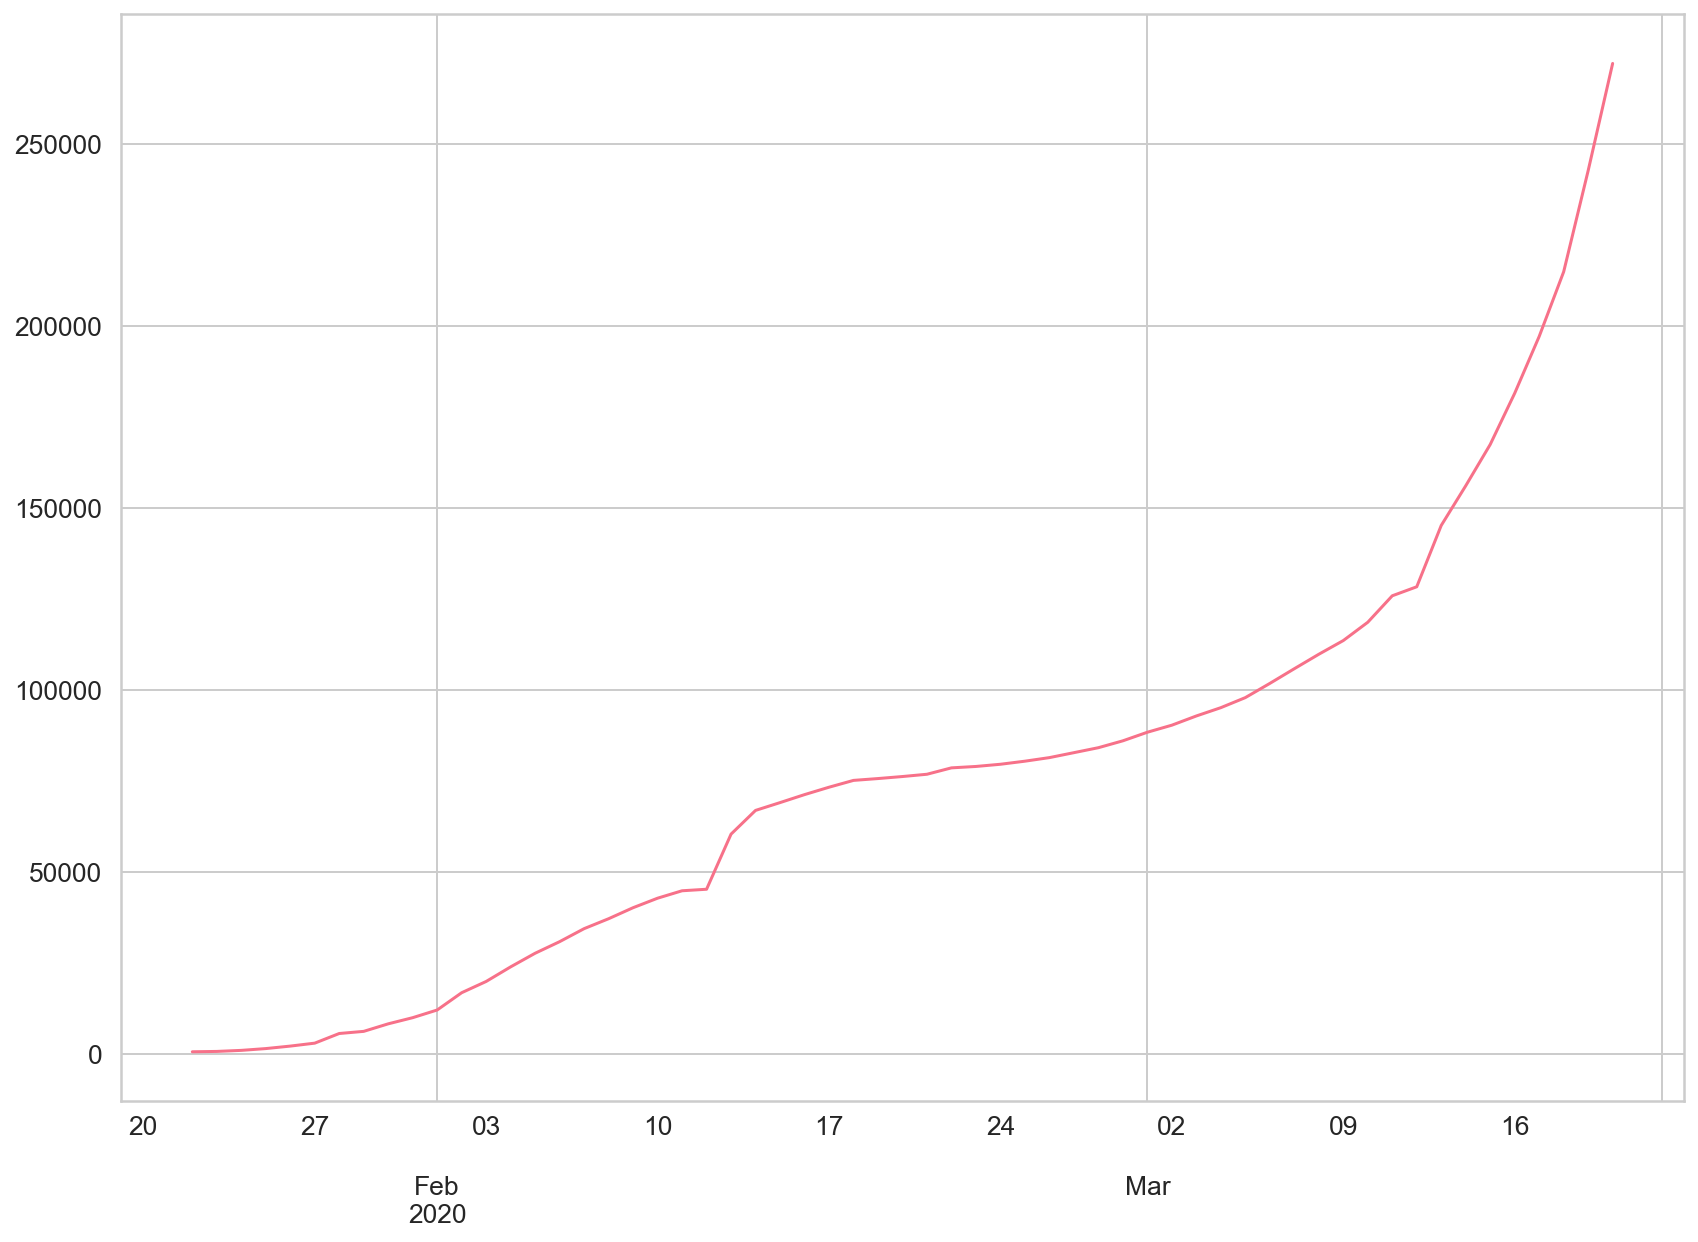

In [101]:
world_data_loader.df.plot(label="Confirmed Cases")

We can then call a method in the class to create our training and testing data sets. Pass in however much you wantfor the training data, but now we only have 56 days, forthis example I'm just going to pass in the last 5. The default value in the method is 0, which will not create a test data.

In [104]:
world_data_loader.gen_data_sets(test_data_size=7)

We then extract these data sets data sets and do some conversions into torch tensors.

In [105]:
X_train, y_train = world_data_loader.set_seq()
X_test, y_test = world_data_loader.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [106]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [107]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=500)

Epoch 0 train loss: 11.122386932373047 test loss: 6.721543312072754
Epoch 20 train loss: 3.3234219551086426 test loss: 3.9656994342803955
Epoch 40 train loss: 2.9508776664733887 test loss: 3.4929137229919434
Epoch 60 train loss: 2.9237093925476074 test loss: 3.3245291709899902
Epoch 80 train loss: 2.942805528640747 test loss: 3.3561465740203857
Epoch 100 train loss: 2.935609817504883 test loss: 3.2809133529663086
Epoch 120 train loss: 2.8547444343566895 test loss: 3.2419519424438477
Epoch 140 train loss: 2.85509991645813 test loss: 3.185767650604248
Epoch 160 train loss: 2.8402836322784424 test loss: 3.142127275466919
Epoch 180 train loss: 2.7617568969726562 test loss: 3.0459787845611572
Epoch 200 train loss: 2.7106096744537354 test loss: 2.944786310195923
Epoch 220 train loss: 2.6096577644348145 test loss: 2.8544230461120605
Epoch 240 train loss: 2.020237445831299 test loss: 2.3052186965942383
Epoch 260 train loss: 0.3536890745162964 test loss: 0.8009682893753052
Epoch 280 train loss:

In [108]:
seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = world_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[197142.   214909.98 242707.98]
[175109.98118615 187082.87394857 198771.71881986]


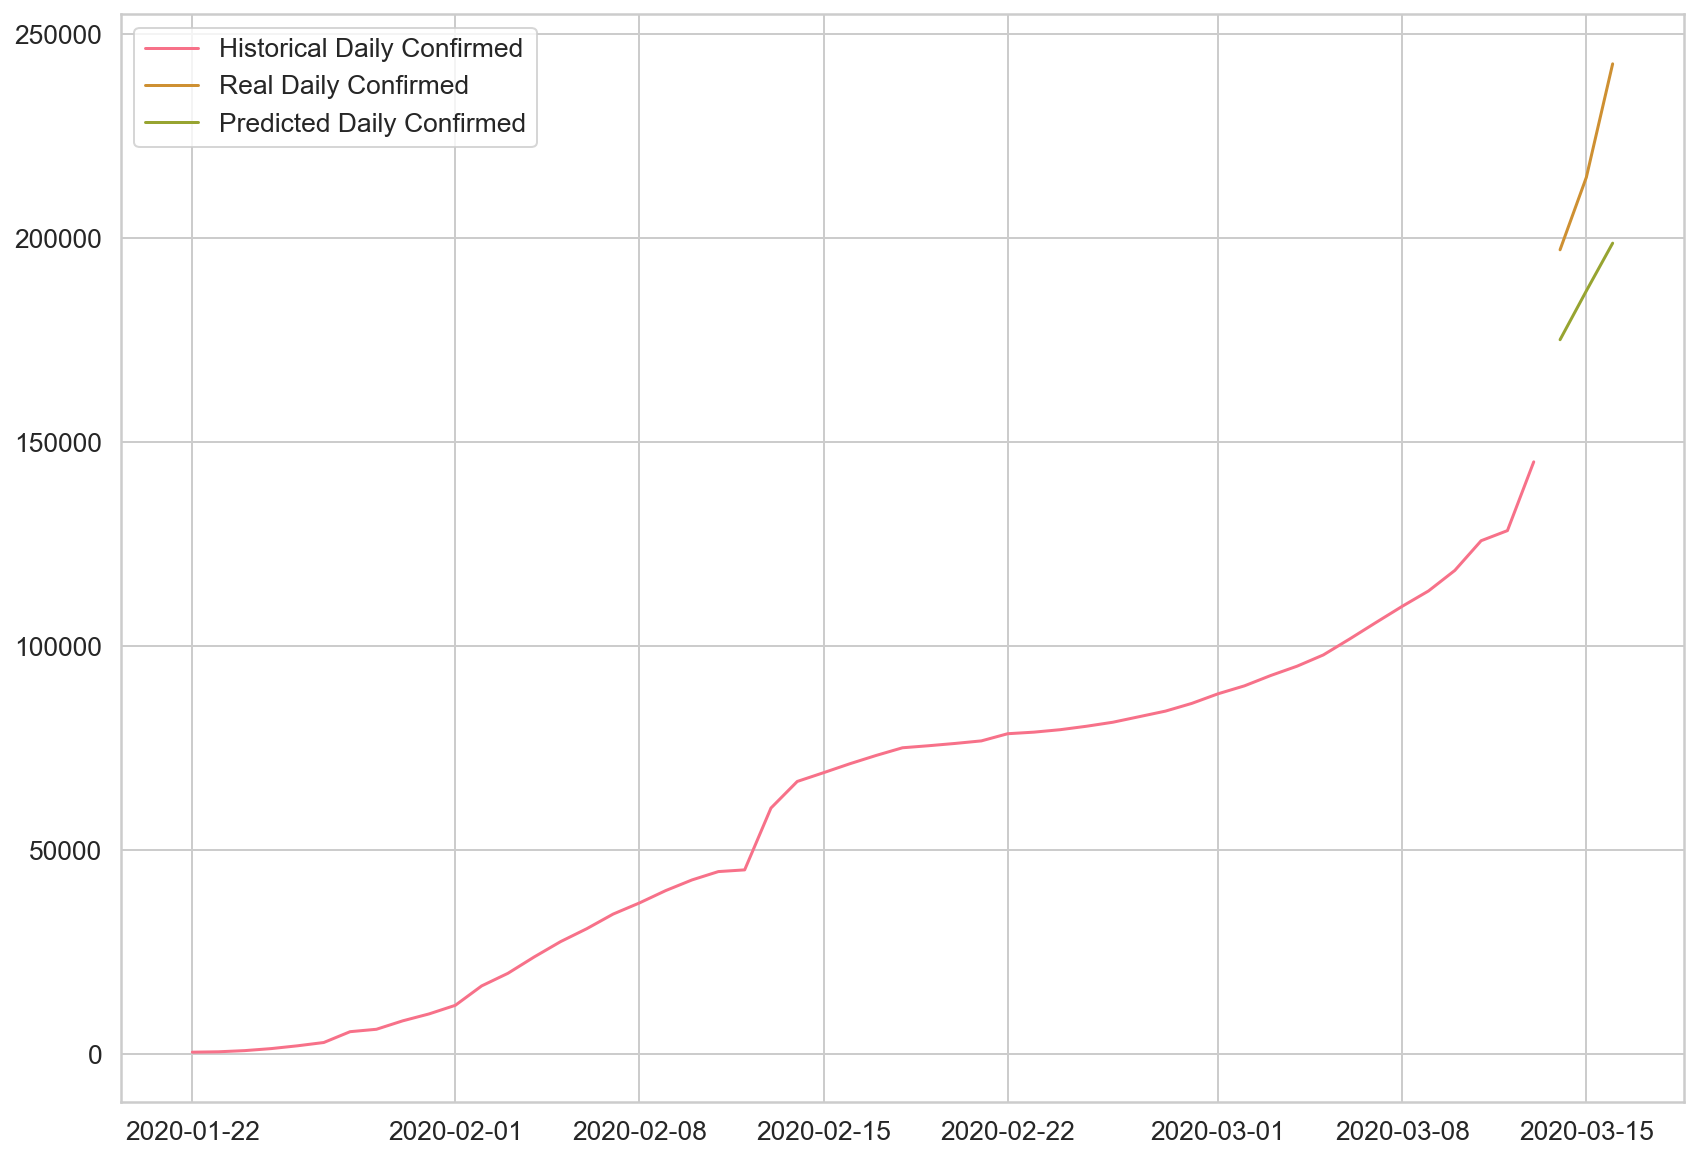

In [109]:
plt.plot(
  world_data_loader.df.index[:len(world_data_loader.train_data)],
  world_data_loader.scaler.inverse_transform(world_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  world_data_loader.df.index[len(world_data_loader.train_data):len(world_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  world_data_loader.df.index[len(world_data_loader.train_data):len(world_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

## World - Future

For our future, prediction, we the only real modifications that we make to our previous analysis is that we keep all of our data as training data for a better fit, and see what the model outputs!

In [38]:
world_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country=None,
                                     region_list=None,
                                     state_mapper=None)

world_data_loader.subset_df()

world_data_loader.transform_df_datetime(delta=True)

world_data_loader.gen_data_sets(test_data_size=0)

X_train, y_train = world_data_loader.set_seq()
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=500)


Data is converted to daily delta
Epoch 0 train loss: 2.046912431716919
Epoch 20 train loss: 1.360359787940979
Epoch 40 train loss: 1.3508174419403076
Epoch 60 train loss: 1.3411896228790283
Epoch 80 train loss: 1.3248306512832642
Epoch 100 train loss: 1.3214905261993408
Epoch 120 train loss: 1.3123667240142822
Epoch 140 train loss: 1.3034882545471191
Epoch 160 train loss: 1.2915650606155396
Epoch 180 train loss: 1.275892972946167
Epoch 200 train loss: 1.2693182229995728
Epoch 220 train loss: 1.2259221076965332
Epoch 240 train loss: 1.2084063291549683
Epoch 260 train loss: 1.1728711128234863
Epoch 280 train loss: 1.1142421960830688
Epoch 300 train loss: 1.0481665134429932
Epoch 320 train loss: 0.9545227885246277
Epoch 340 train loss: 0.8428211212158203
Epoch 360 train loss: 0.7812267541885376
Epoch 380 train loss: 0.7655507326126099
Epoch 400 train loss: 0.769014835357666
Epoch 420 train loss: 0.753128170967102
Epoch 440 train loss: 0.7339538931846619
Epoch 460 train loss: 0.74017500877

In [39]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[11104.72580004 11024.90502703 11151.41332853 11375.97328234
 11649.41748488 11949.47741735 12266.12461019 12594.90370858
 12933.88958979 13282.31121409]


After all that... our model looks pretty inear, predicting an incrase of ~10k cases a day. 

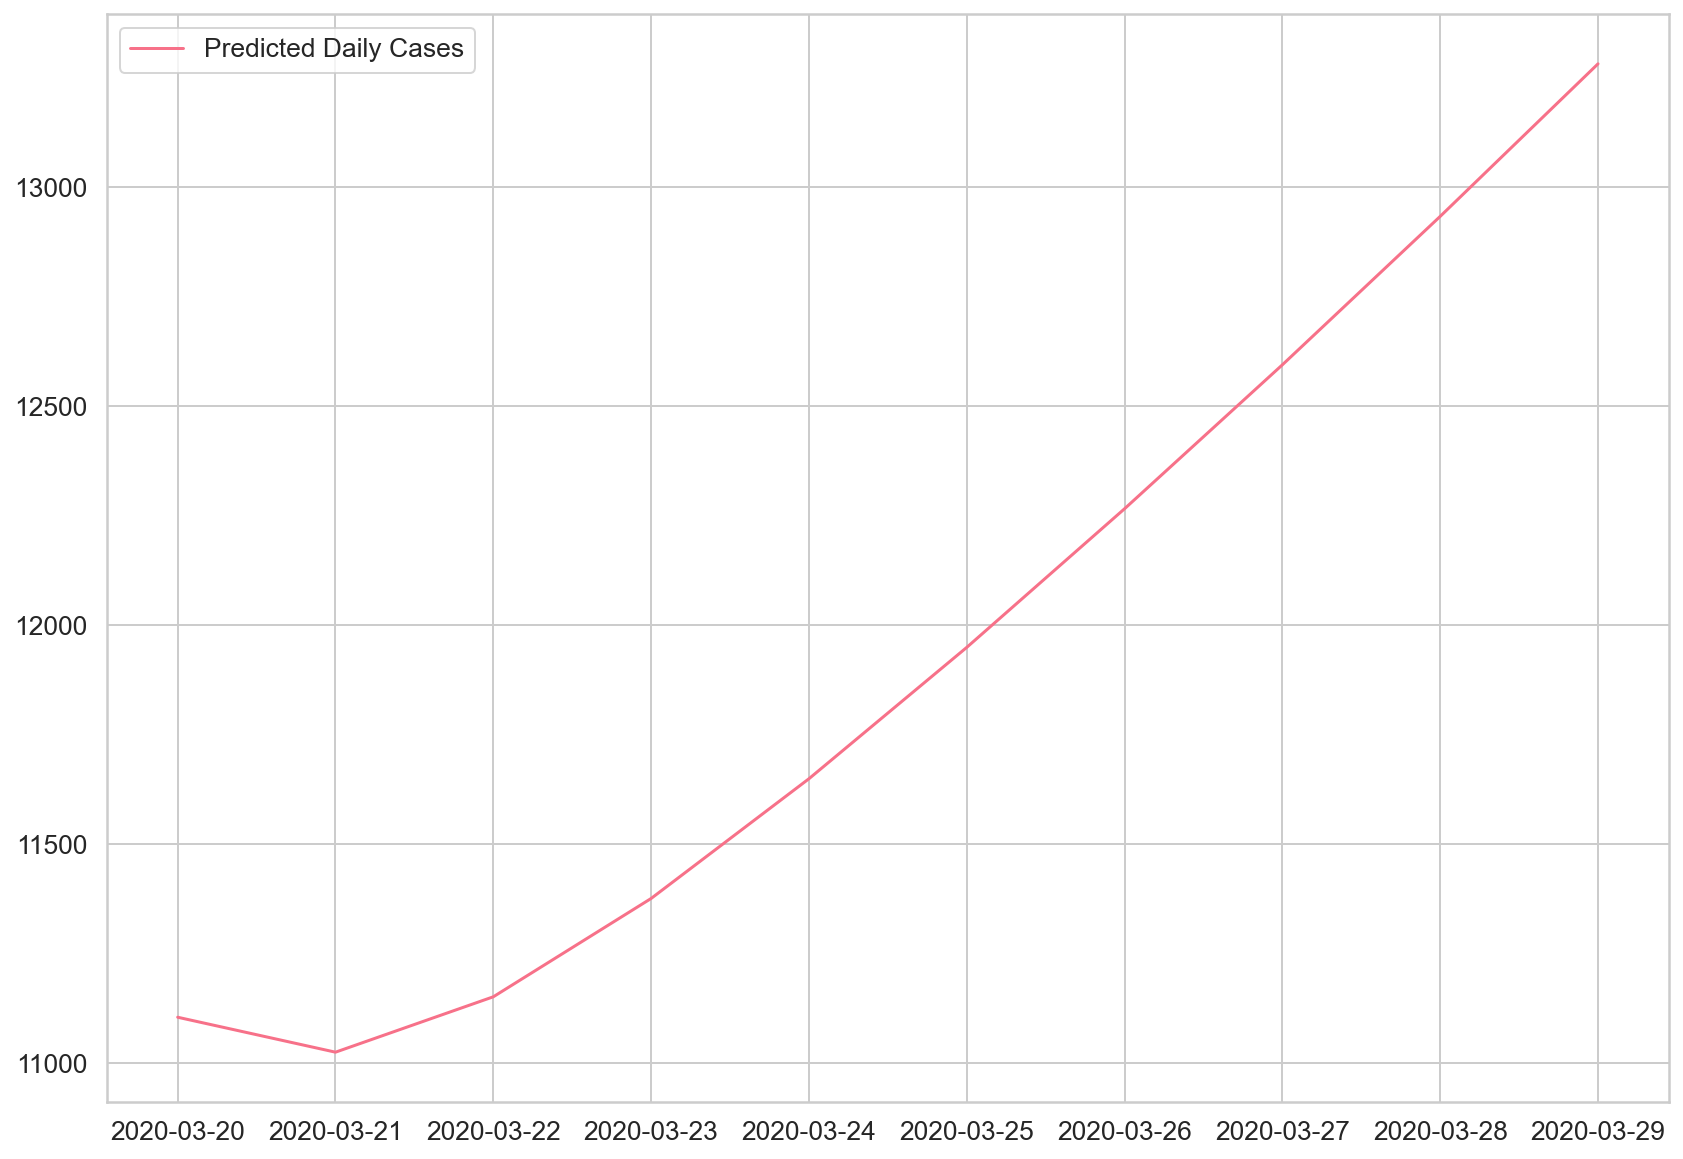

In [40]:
predicted_index = pd.date_range(
  start=world_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

And our data and predictions together.

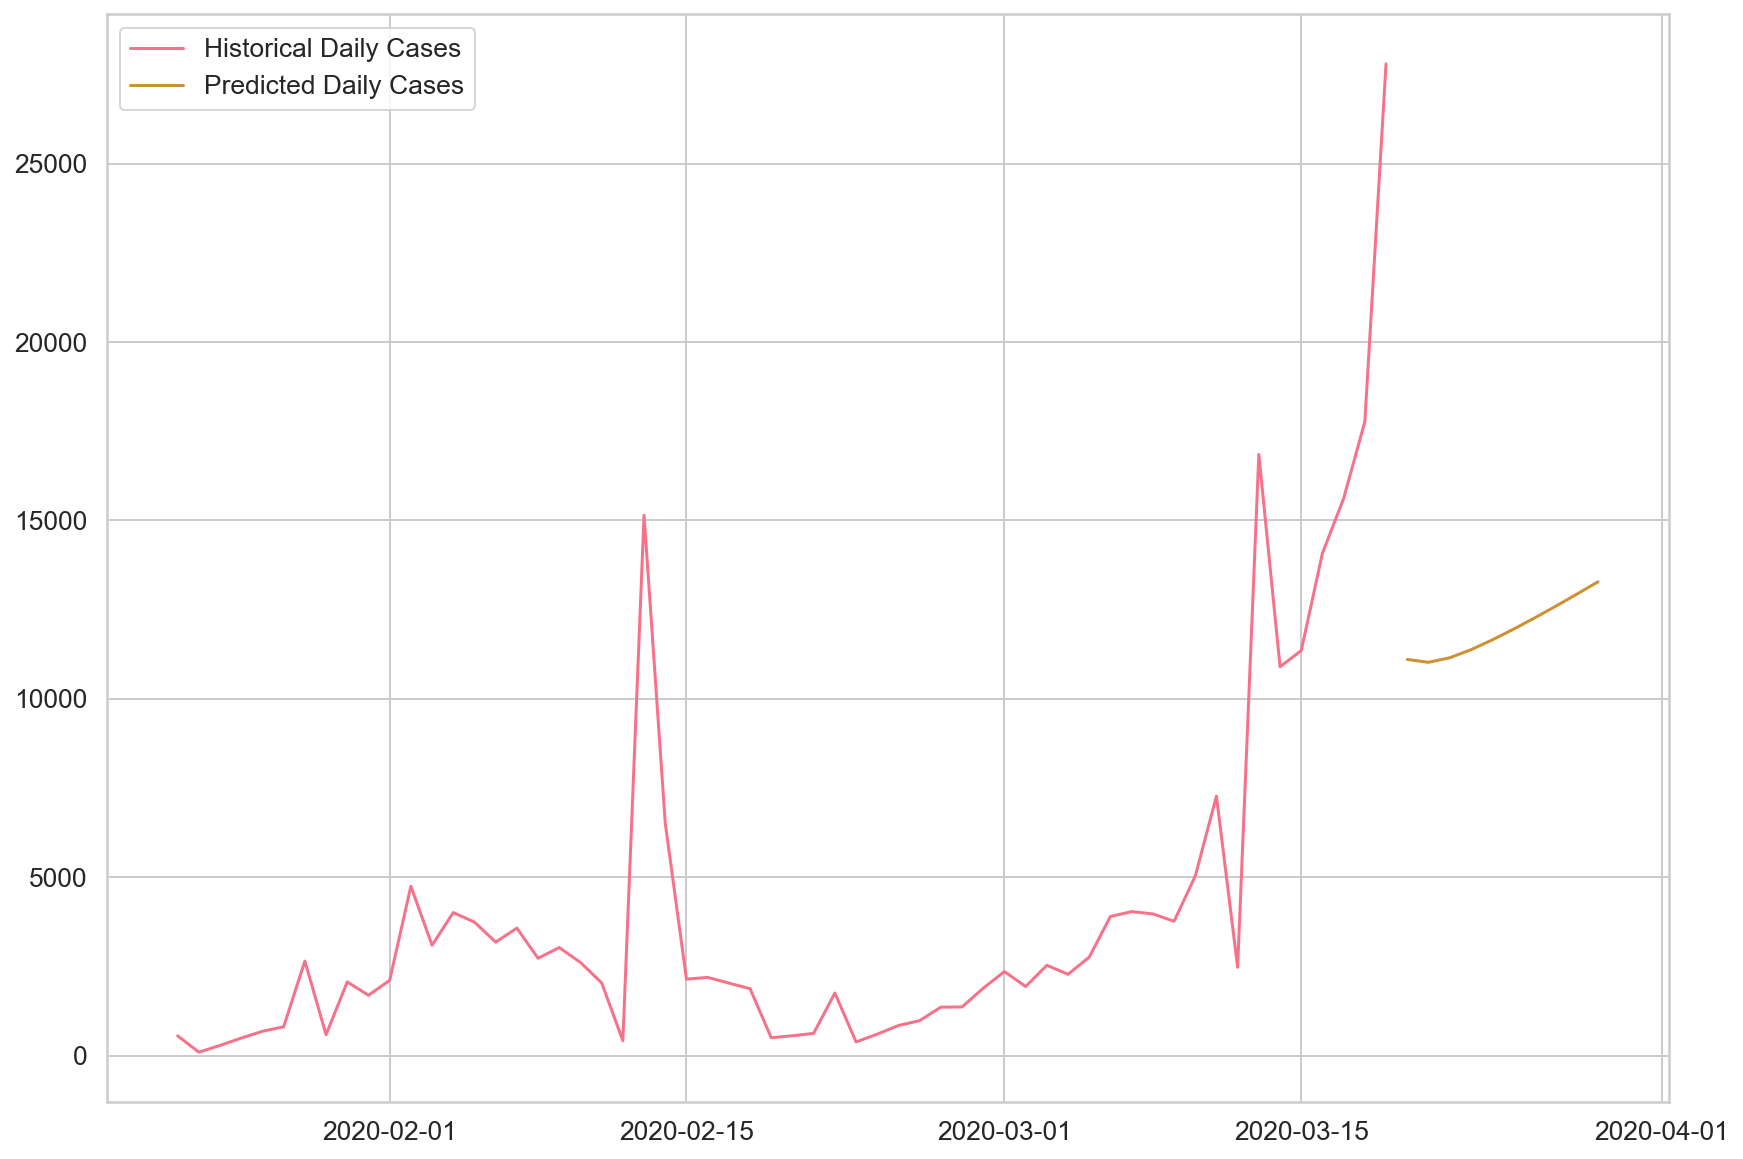

In [41]:
plt.plot(world_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

## Italian Analysis

Okay, lets try something a bit harder that ahs considerabley less data then then aggergating over the whole world. Lets do Italy.

In [42]:
italy_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country='Italy',
                                     region_list=None,
                                     state_mapper=None)

In [43]:
italy_data_loader.subset_df()
italy_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,0,0,0,0,0,0,0,0,0,2,...,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035


In [44]:
italy_data_loader.transform_df_datetime(delta=True)
italy_data_loader.df.head()

Data is converted to daily delta


2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

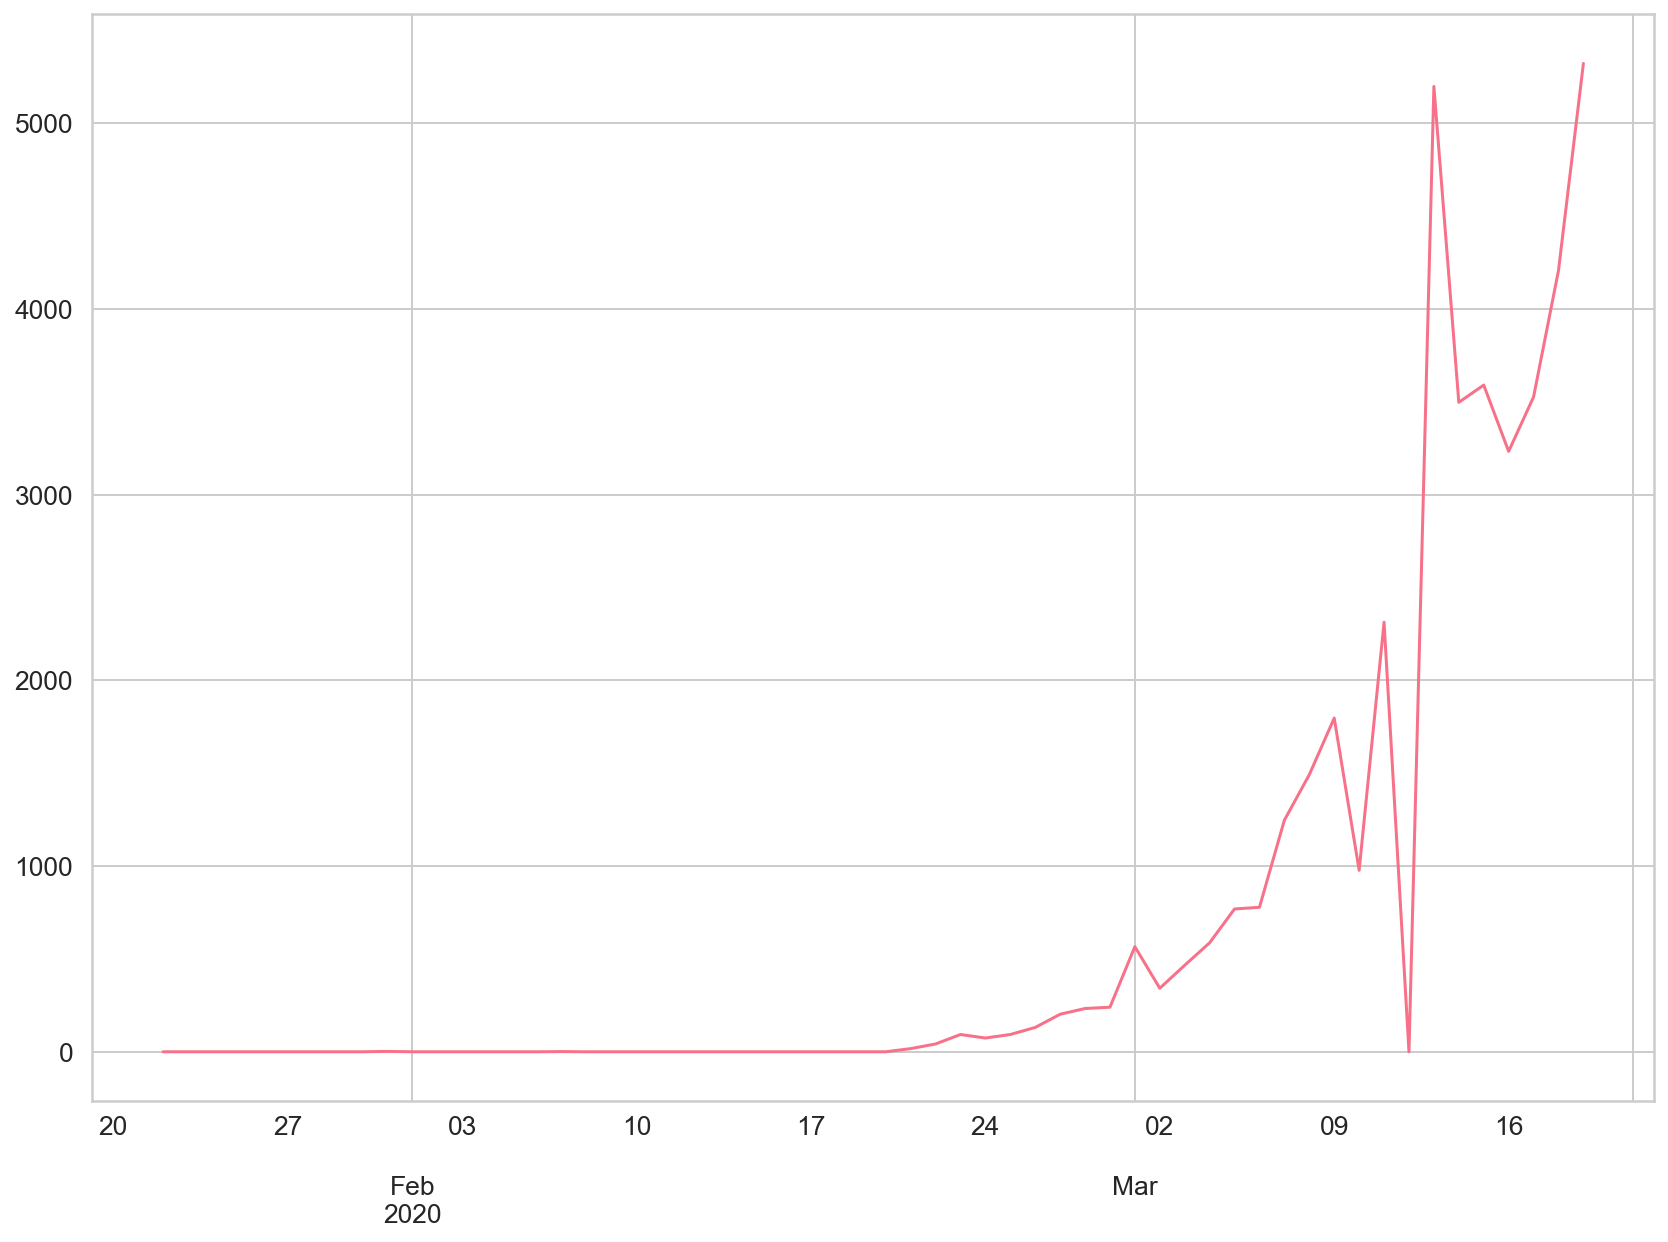

In [45]:
italy_data_loader.df.plot(label="Confirmed Cases")

In [46]:
italy_data_loader.gen_data_sets(test_data_size=7)

In [47]:
X_train, y_train = italy_data_loader.set_seq()
X_test, y_test = italy_data_loader.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [48]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [49]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=300)

Epoch 0 train loss: 3.5778818130493164 test loss: 8.06237506866455
Epoch 20 train loss: 2.272509813308716 test loss: 6.452486991882324
Epoch 40 train loss: 2.2264275550842285 test loss: 6.34193229675293
Epoch 60 train loss: 2.185678482055664 test loss: 6.205051898956299
Epoch 80 train loss: 2.1448841094970703 test loss: 5.979482650756836
Epoch 100 train loss: 2.090528964996338 test loss: 5.7401933670043945
Epoch 120 train loss: 1.9650429487228394 test loss: 5.387097358703613
Epoch 140 train loss: 1.796170711517334 test loss: 4.810112953186035
Epoch 160 train loss: 1.5435173511505127 test loss: 3.9342551231384277
Epoch 180 train loss: 0.8519082069396973 test loss: 1.9374210834503174
Epoch 200 train loss: 0.46803605556488037 test loss: 0.3346473276615143
Epoch 220 train loss: 0.5289811491966248 test loss: 0.6788580417633057
Epoch 240 train loss: 0.4956895112991333 test loss: 0.4088858366012573
Epoch 260 train loss: 0.4933065176010132 test loss: 0.4938572943210602
Epoch 280 train loss: 0.

In [50]:
seq_length = model.sequences

with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = italy_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = italy_data_loader.scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
print(predicted_cases)

[3233. 3526. 4207.]
[3649.09248018 4258.67518222 4864.97447848]


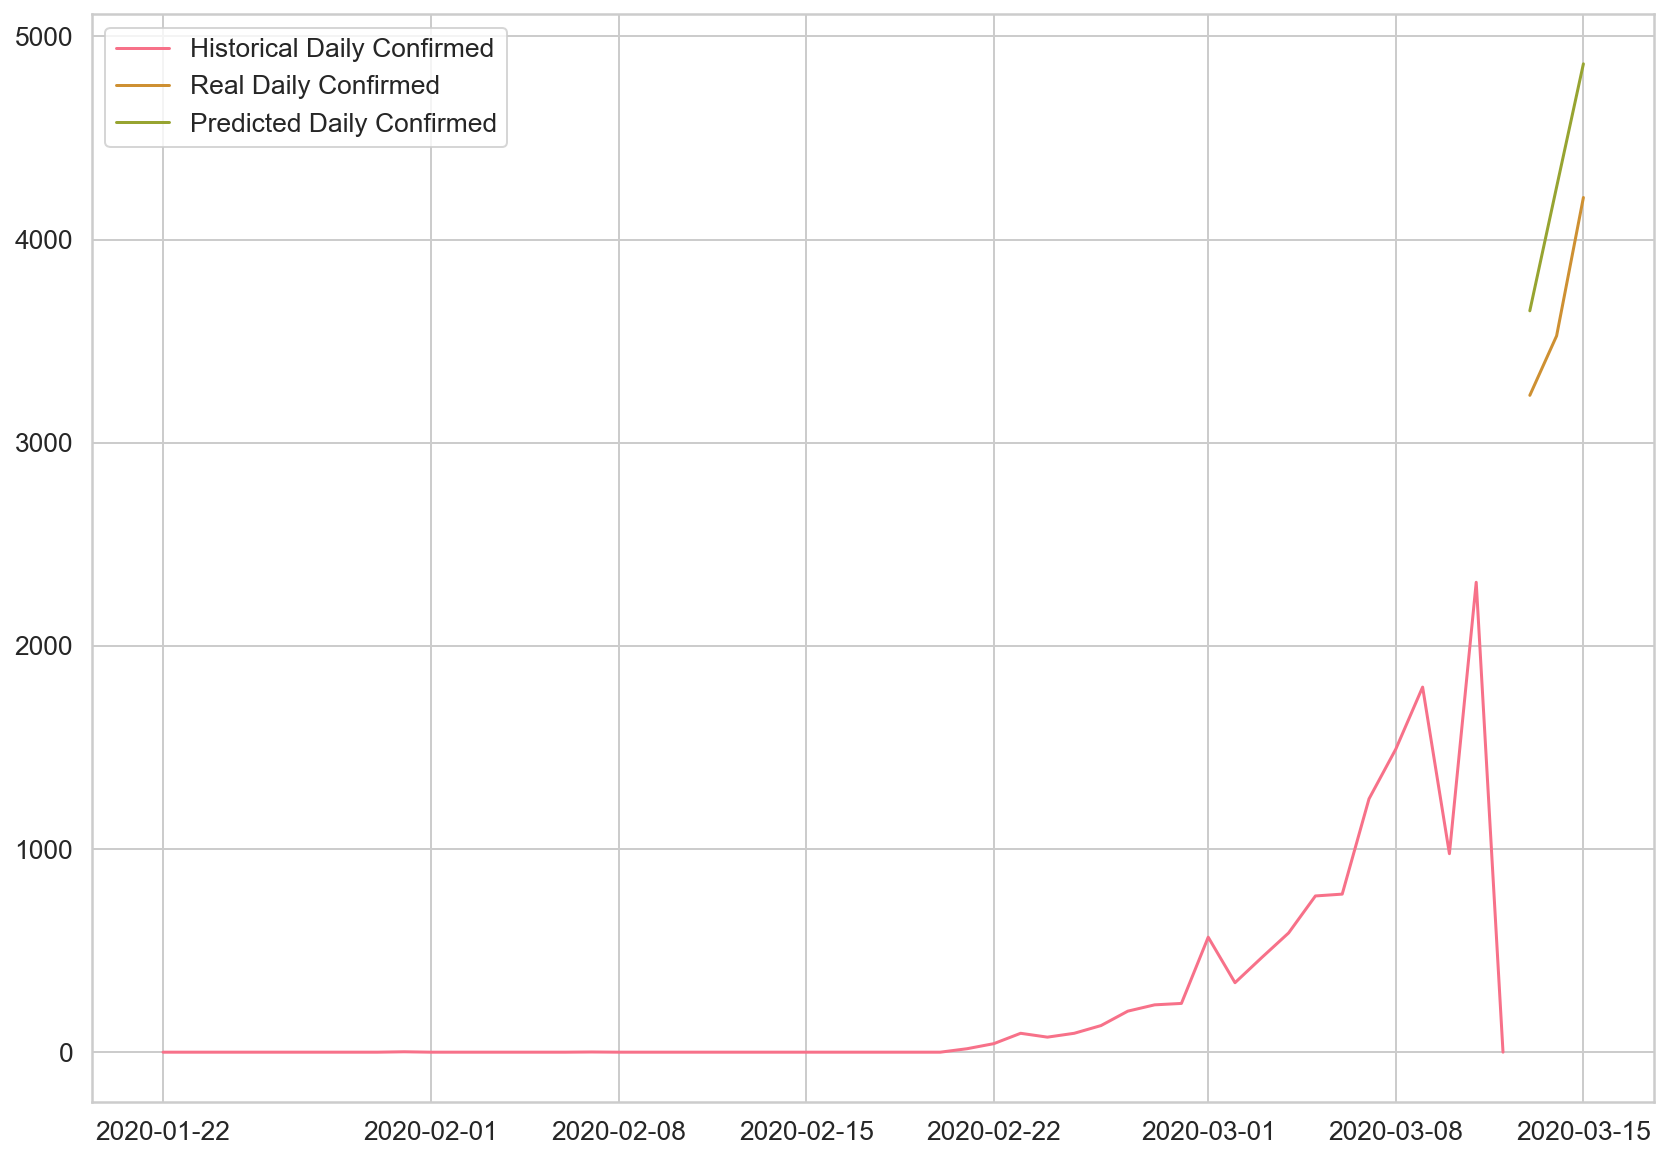

In [51]:
plt.plot(
  italy_data_loader.df.index[:len(italy_data_loader.train_data)],
  italy_data_loader.scaler.inverse_transform(italy_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  italy_data_loader.df.index[len(italy_data_loader.train_data):len(italy_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  italy_data_loader.df.index[len(italy_data_loader.train_data):len(italy_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

## Italy - Future

In [52]:
italy_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country="Italy",
                                     region_list=None,
                                     state_mapper=None)

italy_data_loader.subset_df()

italy_data_loader.transform_df_datetime(delta=True)

italy_data_loader.gen_data_sets(test_data_size=0)

X_train, y_train = italy_data_loader.set_seq()
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=500)


Data is converted to daily delta
Epoch 0 train loss: 3.50907826423645
Epoch 20 train loss: 2.9407598972320557
Epoch 40 train loss: 2.8571202754974365
Epoch 60 train loss: 2.7582664489746094
Epoch 80 train loss: 2.6027634143829346
Epoch 100 train loss: 2.3680081367492676
Epoch 120 train loss: 1.8169541358947754
Epoch 140 train loss: 0.9173377752304077
Epoch 160 train loss: 0.9664306044578552
Epoch 180 train loss: 0.9370050430297852
Epoch 200 train loss: 0.8931858539581299
Epoch 220 train loss: 0.8991881012916565
Epoch 240 train loss: 0.9256232380867004
Epoch 260 train loss: 0.8807938098907471
Epoch 280 train loss: 0.8658771514892578
Epoch 300 train loss: 0.879706084728241
Epoch 320 train loss: 0.8744561672210693
Epoch 340 train loss: 0.9003912210464478
Epoch 360 train loss: 0.8516907095909119
Epoch 380 train loss: 0.8529808521270752
Epoch 400 train loss: 0.860928475856781
Epoch 420 train loss: 0.8336551189422607
Epoch 440 train loss: 0.8552099466323853
Epoch 460 train loss: 0.8640922307

In [53]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[21751.95556688 24218.85671425 27202.9439013  30673.75362921
 34608.09691954 38976.22352648 43730.4742794  48797.51289892
 54075.63148546 59438.84181786]


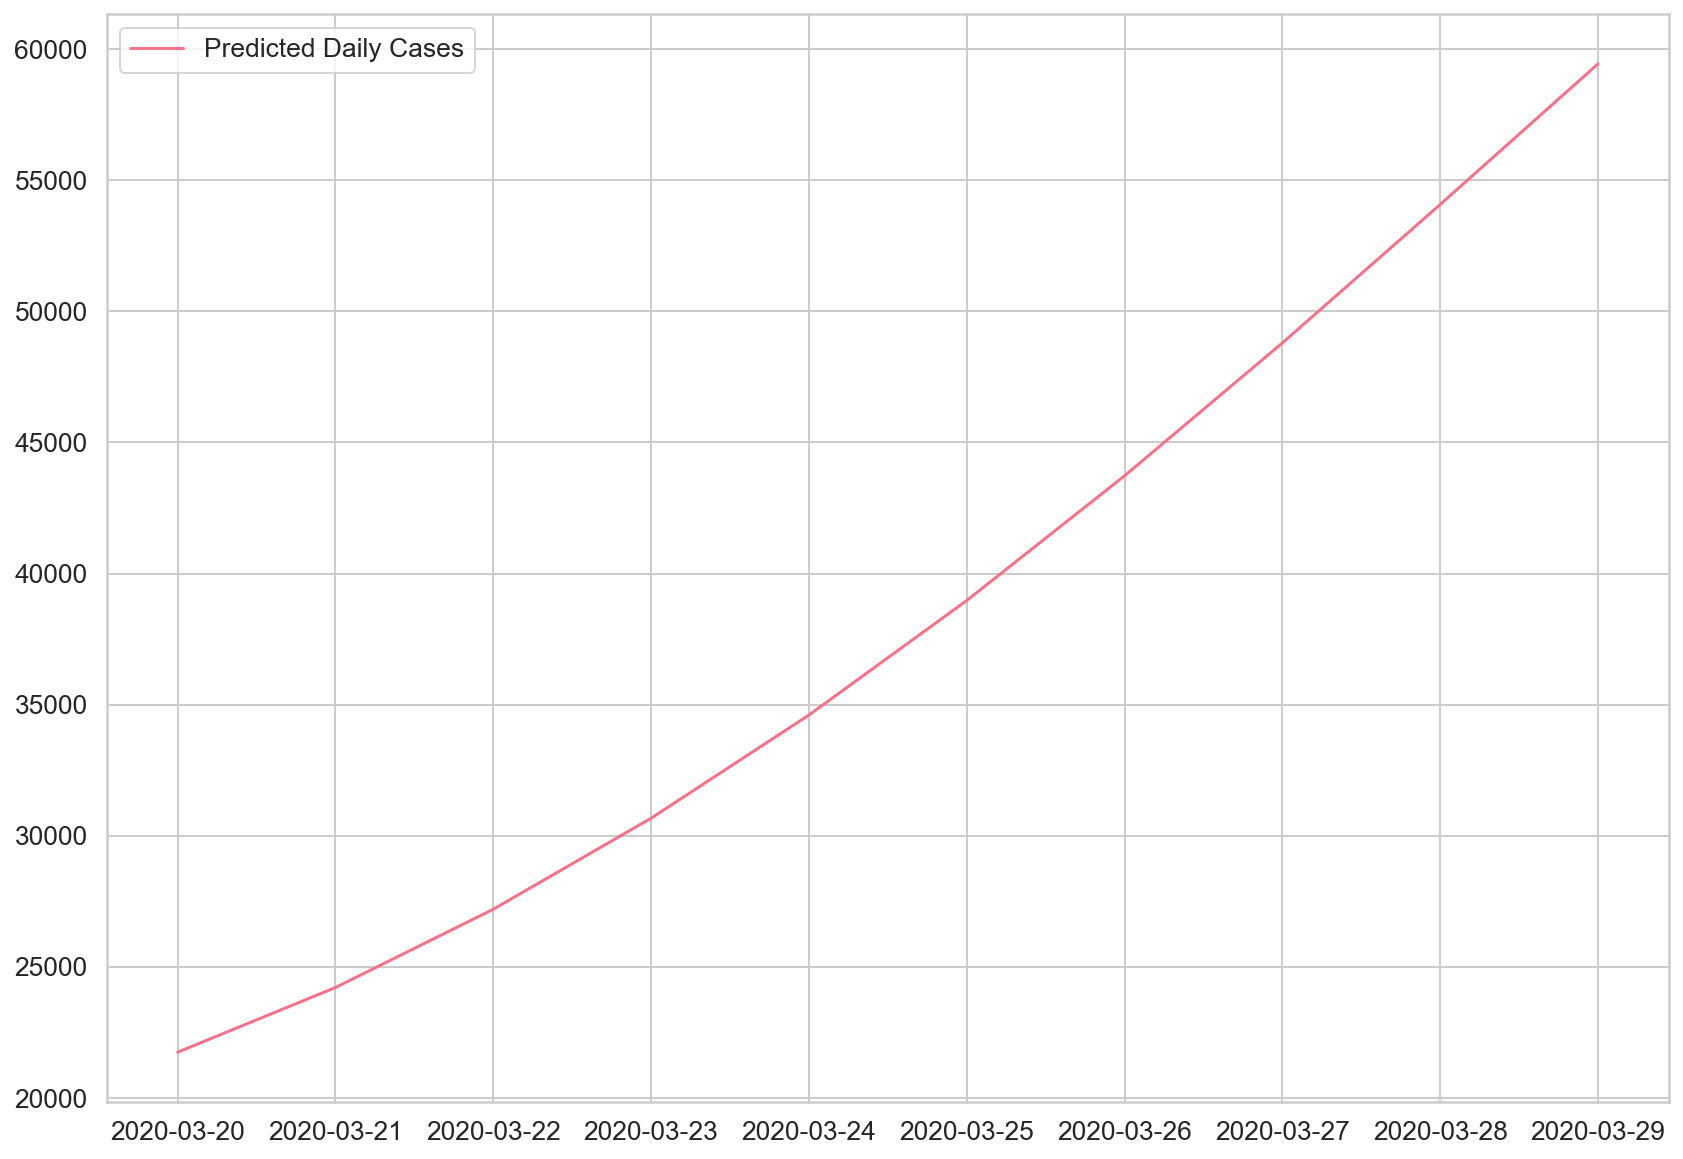

In [54]:
predicted_index = pd.date_range(
  start=world_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

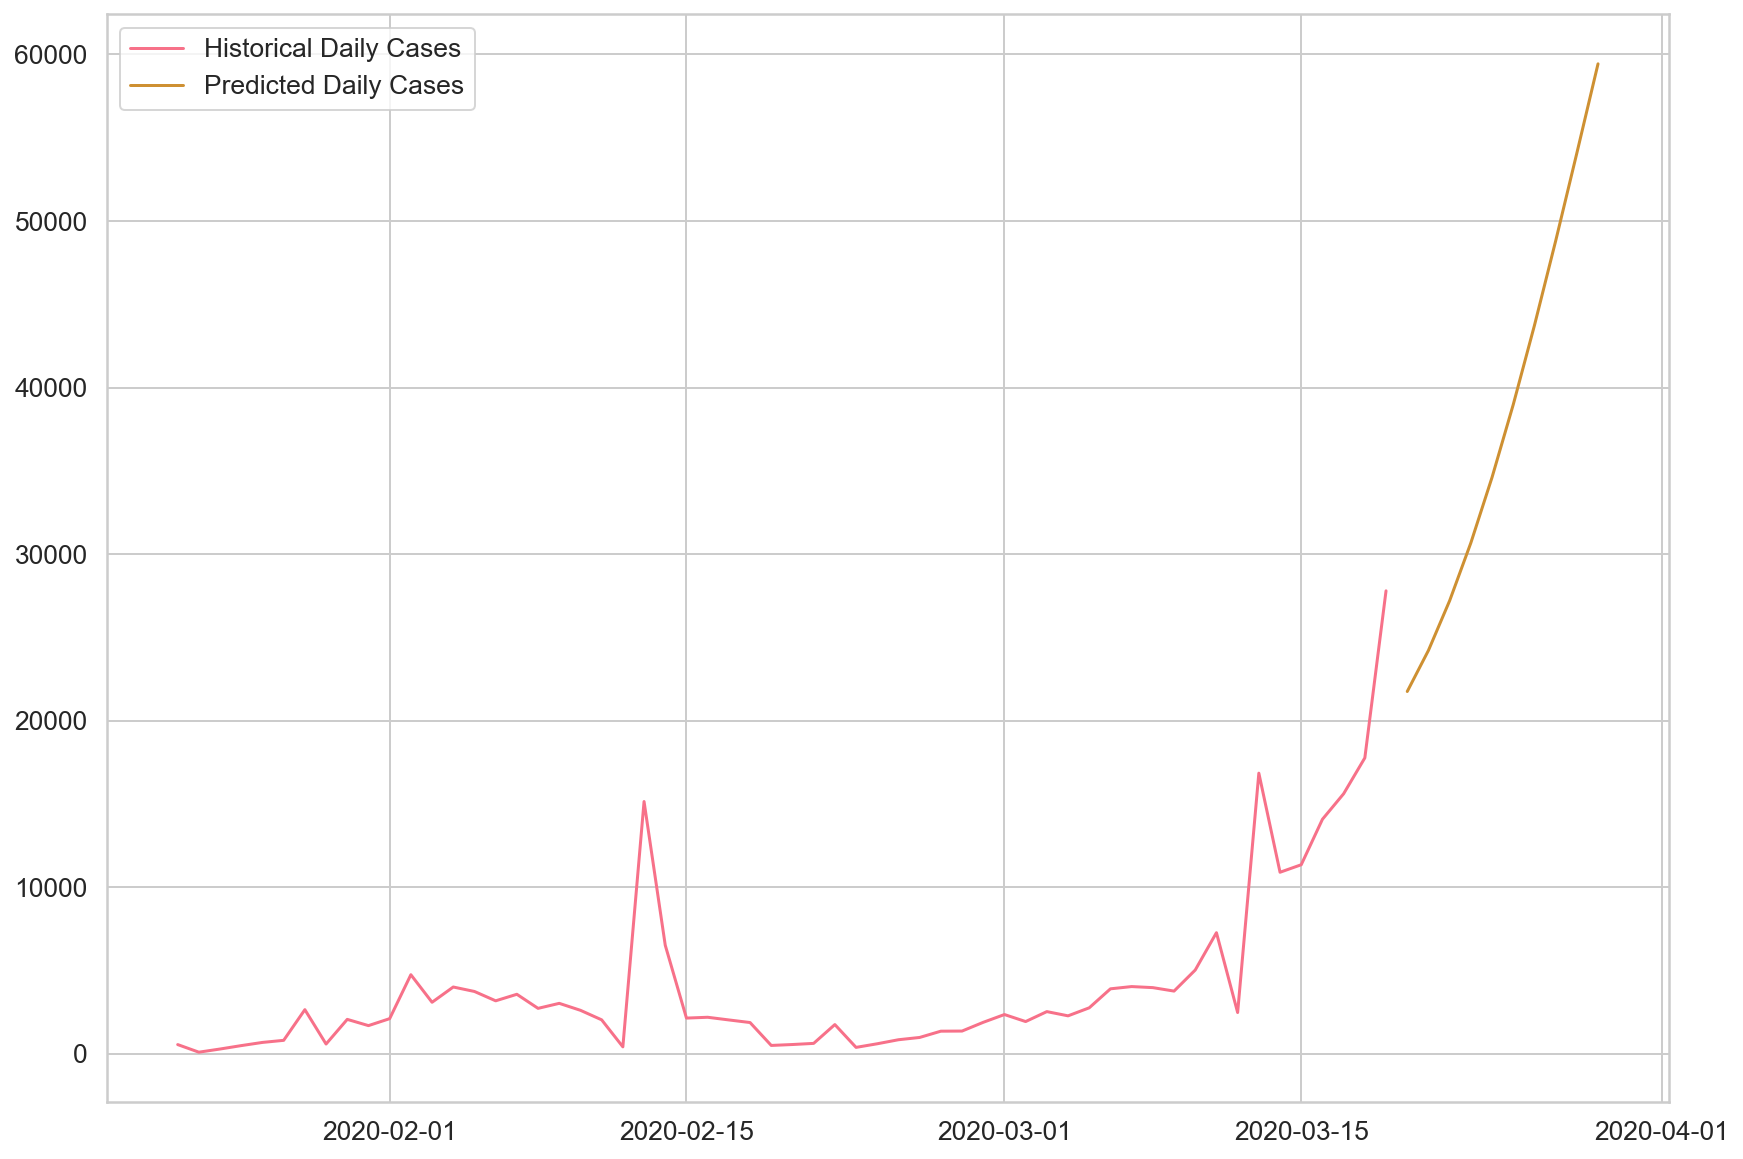

In [55]:
plt.plot(world_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

Lets collect data for prediction for all of the countries in our data set.

In [42]:
country_list = tdf['Country/Region'].tolist()
print(len(country_list))
country_list = list(dict.fromkeys(country_list))
print(len(country_list))

482
166


In [ ]:
data_saver = {}

counter = 1

for country in country_list:
    
    print('{}: {} out of {}'.format(country, counter, len(country_list)))
    
    country_data_loader = LSTM_data_loader(df=tdf,
                                           region_abr=None,
                                           country=country,
                                           region_list=None,
                                           state_mapper=None)
    
    country_data_loader.subset_df()

    country_data_loader.transform_df_datetime(delta=False)

    country_data_loader.gen_data_sets(test_data_size=0)
    
    X_train, y_train = country_data_loader.set_seq()
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    
    model = LSTM_Predictor(features=1,
                           neurons=512,
                           sequences=3,
                           layers=2,
                           dropout=0.3)

    model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=300)
    
    seq_length = model.sequences
    days_to_predict = 10

    outs = predict_future(n_future=days_to_predict, 
                          time_data=X_train, 
                          sequece_lenth=model.sequences, 
                          model=model)

    predicted_cases = country_data_loader.scaler.inverse_transform(
      np.expand_dims(outs, axis=0)
    ).flatten()
    print(predicted_cases)
    
    data_saver[country] = predicted_cases
    counter+=1
    

Thailand: 1 out of 166
Data in cumulative
Epoch 0 train loss: 2.7473950386047363
Epoch 40 train loss: 1.1932158470153809
Epoch 80 train loss: 1.1803321838378906
Epoch 120 train loss: 1.1544106006622314
Epoch 160 train loss: 1.1332579851150513
Epoch 200 train loss: 1.1229958534240723
Epoch 240 train loss: 1.0932378768920898
Epoch 280 train loss: 1.0339367389678955
[70.51488224 66.7632996  63.41505593 60.69537625 58.58485542 56.98681521
 55.79358277 54.9098755  54.25857875 53.77997178]
Japan: 2 out of 166
Data in cumulative
Epoch 0 train loss: 8.58962345123291
Epoch 40 train loss: 4.372207164764404
Epoch 80 train loss: 3.219377040863037
Epoch 120 train loss: 0.3812611997127533
Epoch 160 train loss: 0.3094925284385681
Epoch 200 train loss: 0.29390981793403625
Epoch 240 train loss: 0.2969500422477722
Epoch 280 train loss: 0.2795608341693878
[1083.38713837 1177.6778121  1285.22338605 1404.4256258  1533.23058367
 1669.14406896 1809.27230239 1950.44759703 2089.4439826  2223.24043989]
Singapor

In [111]:
data_saver

{'Thailand': array([4894.35909796, 4762.60293829, 4653.34974635, 4570.84395546,
        4511.49948794, 4470.00574577, 4441.49791408, 4422.13028777,
        4409.06966734, 4400.30590105]),
 'Japan': array([29744.73826694, 32472.00648594, 35592.68327761, 39071.44940901,
        42858.85597277, 46889.62380695, 51082.46187973, 55343.00615597,
        59570.2784996 , 63665.57922173]),
 'Singapore': array([20437.94537592, 21896.26382399, 23585.92225718, 25496.67261648,
        27621.74395132, 29955.11818933, 32488.96275568, 35211.25471401,
        38103.85234165, 41141.08843613]),
 'Nepal': array([27470.1842885 , 27255.93761015, 27160.33859062, 27135.04122305,
        27150.40918398, 27188.11583328, 27236.85809183, 27289.71806574,
        27342.56483126, 27393.03078461]),
 'Malaysia': array([17603.55051565, 20159.75028086, 23337.81752396, 27148.34207106,
        31624.45716667, 36802.24152613, 42702.19787169, 49309.90924644,
        56557.1080904 , 64307.85696316]),
 'Canada': array([5299.25

## US States Analysis

### CA

To do our analyses on US States, we can just feed in an abbreviation, but we have a good amount of disparatae naming that takes place in our data set that looks like so.

In [56]:
# some state names
tdf[tdf['Country/Region']=='US'][:5]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,267,366,442,568,572,643,904,1076,1014,1376
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,173,220,328,421,525,732,967,1706,2495,5365
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,144,177,221,282,340,426,557,698,751,952
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,92,95,108,123,138,164,197,218,218,328
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,46,46,46,46,47,47,47,47


In [57]:
# some mixed types
tdf[tdf['Country/Region']=='US'][-5:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
399,"New Castle, DE",US,39.5393,-75.6674,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
414,Alabama,US,32.3182,-86.9023,0,0,0,0,0,0,...,0,0,0,5,6,12,29,39,46,78
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,0,0,0,0,3,5,5,5,5,5
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,0,0,0,0,3,3,3,5,12
448,Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,0,0,0,1,1,1,2,2,3


So lets get some of this from a hand json we were already using for geospatial information in our visualization to get some name metadata.

In [58]:
with open('./data/us-states.json', 'r') as f:
    us_states = json.load(f)
    
state_abrs = [x['id'] for x in us_states['features']]

state_mapper_lst = [{x['properties']['name']:x['id']} for x in us_states['features']]

state_mapper_lst
state_mapper = {}
for s in state_mapper_lst:
    state_mapper.update(s)

First, lets pick a state that has a considerable outbreak, California.

In [67]:
ca_data_loader = LSTM_data_loader(df=tdf,
                          region_abr='CA',
                          country='US',
                          region_list=state_abrs,
                          state_mapper=state_mapper)

In [68]:
ca_data_loader.subset_df()
ca_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20
0,0,0,0,0,2,2,2,2,2,3,...,144,177,221,282,340,426,557,698,751,952


In [69]:
ca_data_loader.transform_df_datetime()
ca_data_loader.df.head()

Data in cumulative


2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    2
dtype: int64

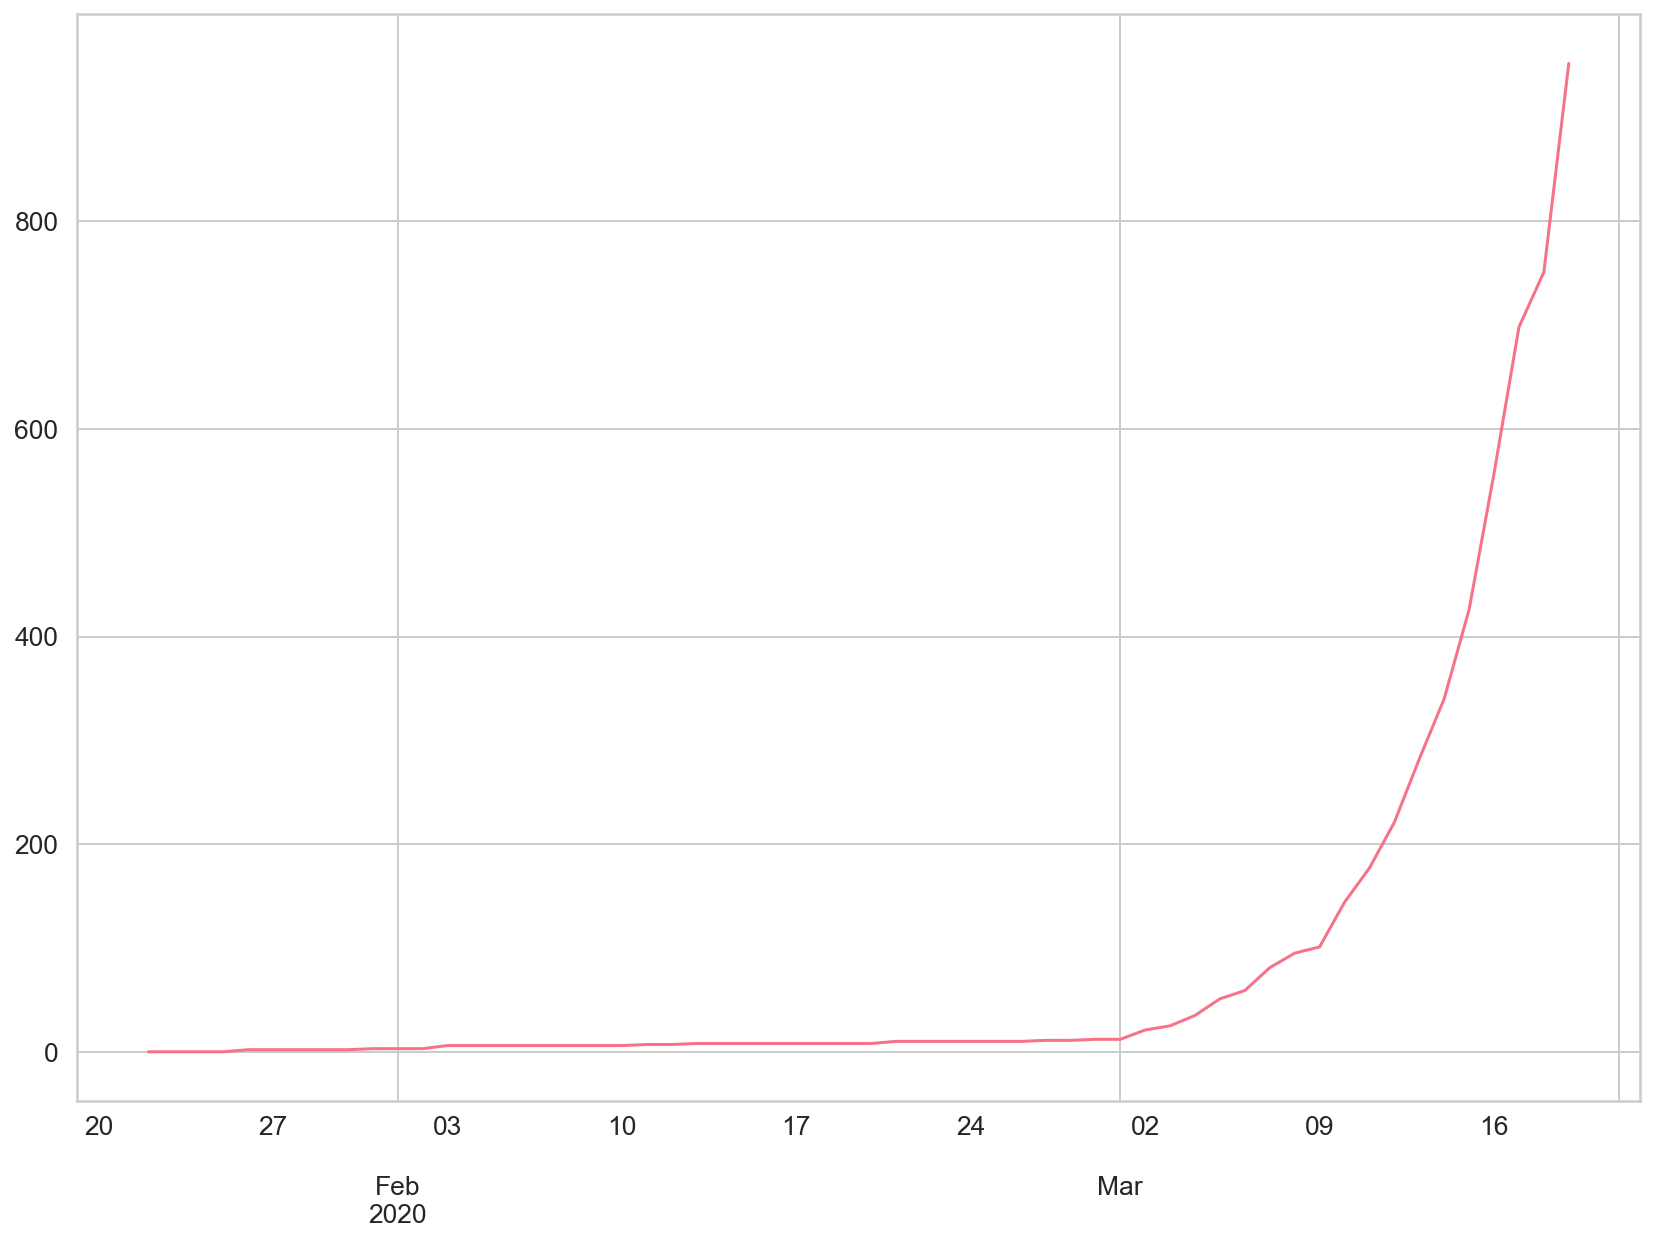

In [70]:
ca_data_loader.df.plot(label="Confirmed Cases")

In [63]:
ca_data_loader.gen_data_sets(test_data_size=7)

In [64]:
X_train, y_train = ca_data_loader.set_seq()
X_test, y_test = ca_data_loader.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [65]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [66]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=300)

Epoch 0 train loss: 2.8205199241638184 test loss: 21.465656280517578
Epoch 20 train loss: 1.7929354906082153 test loss: 19.114809036254883
Epoch 40 train loss: 1.785347819328308 test loss: 19.088260650634766
Epoch 60 train loss: 1.77772855758667 test loss: 18.871620178222656
Epoch 80 train loss: 1.774096965789795 test loss: 18.72753143310547
Epoch 100 train loss: 1.7281605005264282 test loss: 18.541706085205078
Epoch 120 train loss: 1.7257276773452759 test loss: 18.281734466552734
Epoch 140 train loss: 1.6922624111175537 test loss: 17.94676971435547
Epoch 160 train loss: 1.6655497550964355 test loss: 17.60354995727539
Epoch 180 train loss: 1.6325268745422363 test loss: 17.134702682495117
Epoch 200 train loss: 1.5464766025543213 test loss: 16.322853088378906
Epoch 220 train loss: 1.4561376571655273 test loss: 15.505248069763184
Epoch 240 train loss: 1.2733228206634521 test loss: 13.96523380279541
Epoch 260 train loss: 0.9552369117736816 test loss: 11.371594429016113
Epoch 280 train loss

In [108]:
seq_length = model.sequences

with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = ca_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = ca_data_loader.scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
print(predicted_cases)

[340. 426. 557.]
[381.43003464 454.73335648 526.51754379]


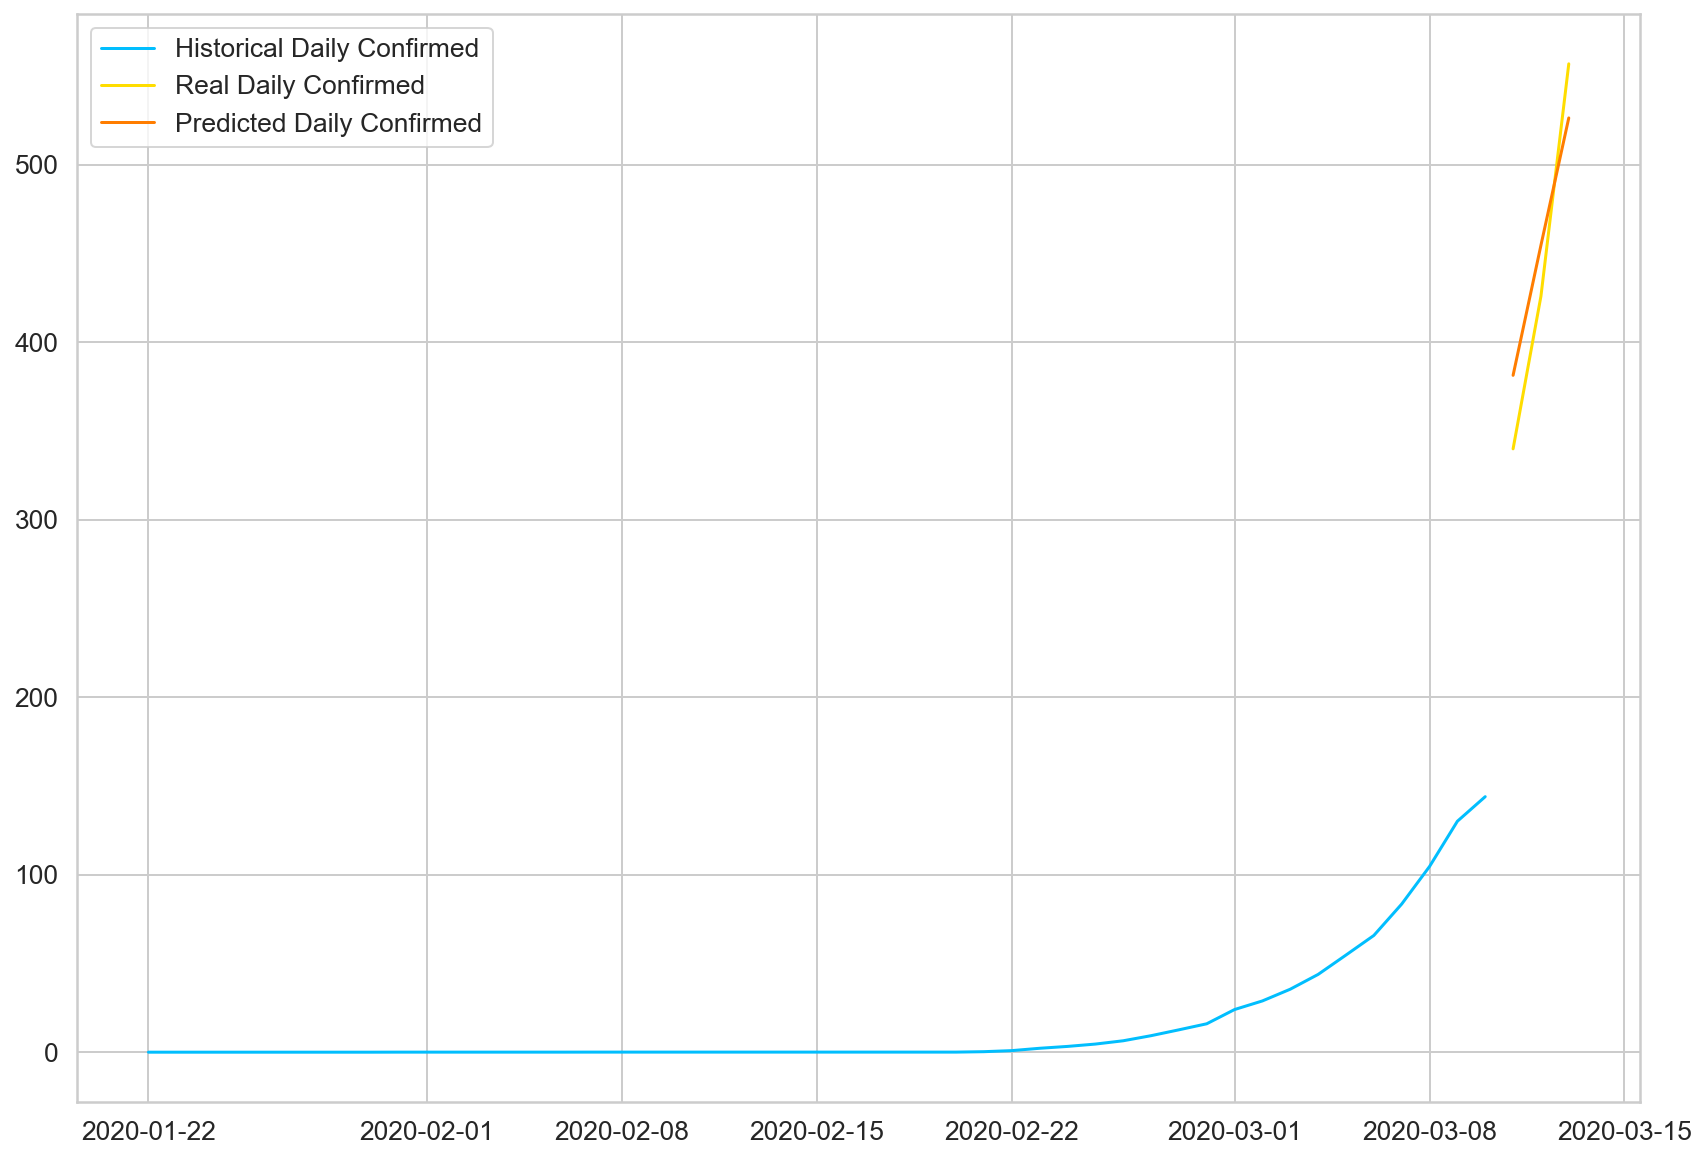

In [109]:
plt.plot(
  ca_data_loader.df.index[:len(ca_data_loader.train_data)],
  ca_data_loader.scaler.inverse_transform(italy_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  ca_data_loader.df.index[len(ca_data_loader.train_data):len(ca_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  ca_data_loader.df.index[len(ca_data_loader.train_data):len(ca_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

### CO

Lets try a state with some cases, but considerable less data, Colorado.

In [15]:
co_data_loader = LSTM_data_loader(df=tdf,
                          region_abr='CO',
                          country='US',
                          region_list=state_abrs,
                          state_mapper=state_mapper)

In [16]:
co_data_loader.subset_df()
co_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,0,0,0,0,0,0,0,0,0,0,...,7,7,15,34,45,49,101,131,160,160


In [17]:
co_data_loader.transform_df_datetime()
co_data_loader.df.head()

2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

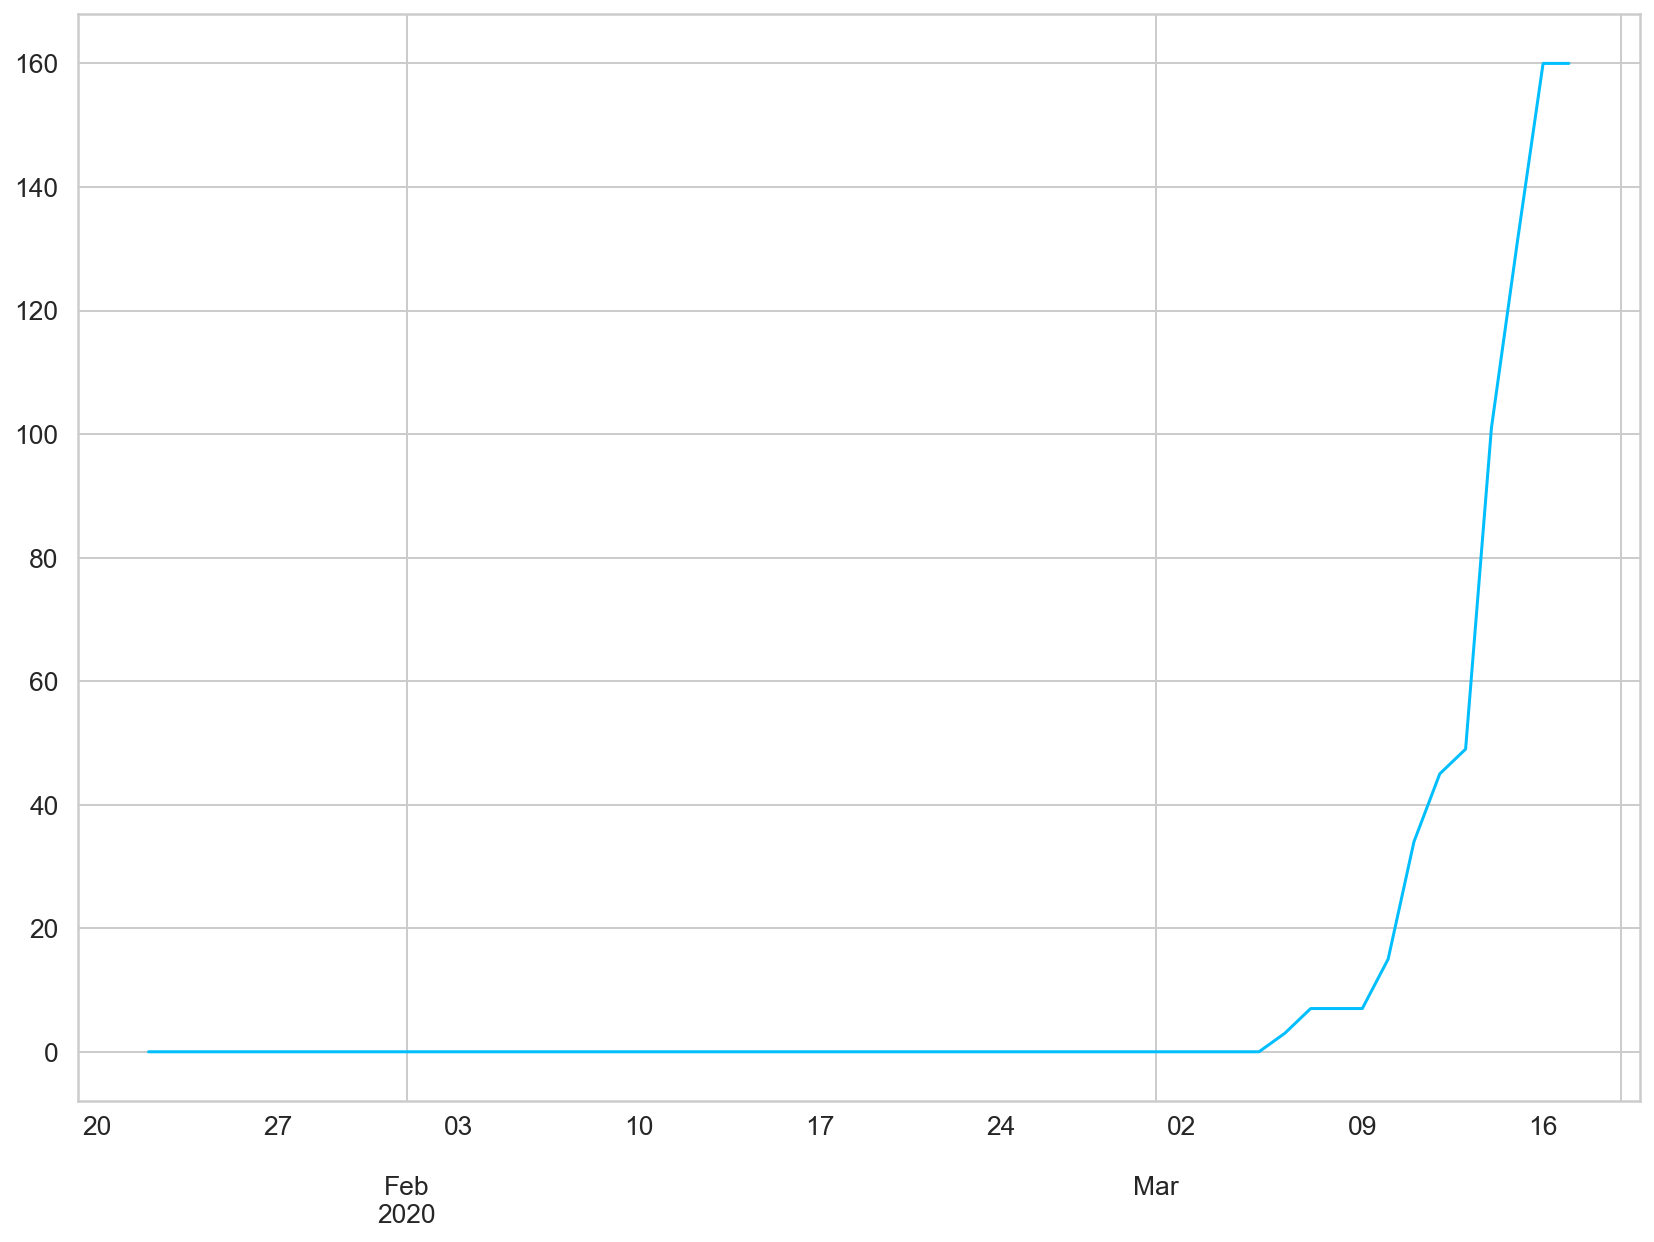

In [18]:
co_data_loader.df.plot(label="Confirmed Cases")

In [19]:
co_data_loader.gen_data_sets(test_data_size=0)

In [20]:
X_train, y_train = co_data_loader.set_seq()
# X_test, y_test = co_data_loader.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
# X_test = torch.from_numpy(X_test).float()
# y_test = torch.from_numpy(y_test).float()

In [21]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [22]:
model, train_hist, test_hist = train_lstm(model,
                                          X_train,
                                          y_train,
                                          epochs=300)

Epoch 0 train loss: 2.1966371536254883
Epoch 20 train loss: 2.0544867515563965
Epoch 40 train loss: 2.043541431427002
Epoch 60 train loss: 2.028346538543701
Epoch 80 train loss: 2.0070838928222656
Epoch 100 train loss: 1.9903323650360107
Epoch 120 train loss: 1.9673469066619873
Epoch 140 train loss: 1.926859974861145
Epoch 160 train loss: 1.8918440341949463
Epoch 180 train loss: 1.8268221616744995
Epoch 200 train loss: 1.730825662612915
Epoch 220 train loss: 1.580679178237915
Epoch 240 train loss: 1.3450826406478882
Epoch 260 train loss: 1.008018136024475
Epoch 280 train loss: 0.6542141437530518


In [131]:
seq_length = model.sequences

with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = co_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = co_data_loader.scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()
print(predicted_cases)

[101. 131. 160.]
[55.27002096 56.60356522 56.55660868]


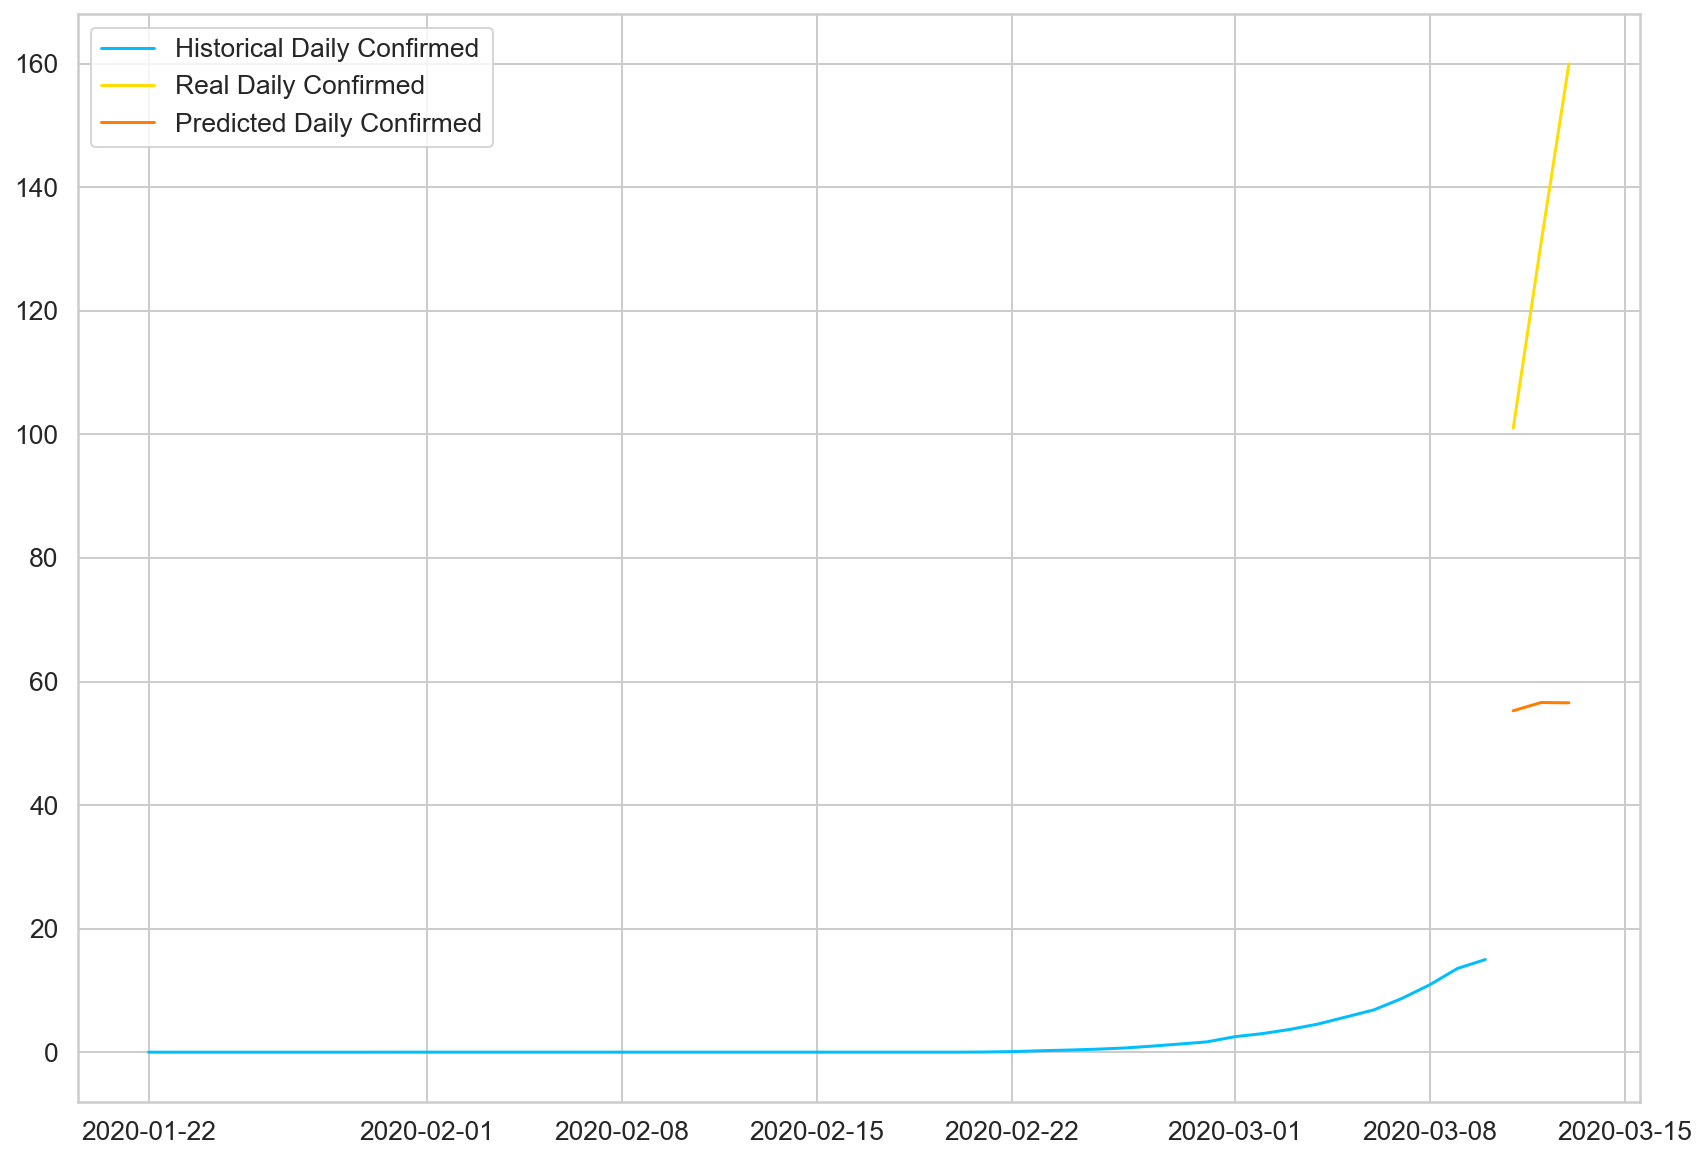

In [132]:
plt.plot(
  co_data_loader.df.index[:len(italy_data_loader.train_data)],
  co_data_loader.scaler.inverse_transform(italy_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  co_data_loader.df.index[len(co_data_loader.train_data):len(co_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  co_data_loader.df.index[len(co_data_loader.train_data):len(co_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.legend()

In [63]:
test_dl.df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,50,50,53,59,70,75,82,114,147,177
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,502,511,581,639,639,701,773,839,825,878
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,150,150,160,178,178,200,212,226,243,266
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,99,117,129,149,149,197,238,428,566,673


In [64]:
test_dl.subset_df()
test_dl.transform_df_datetime()
test_dl.gen_data_sets(test_data_size=5)

X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

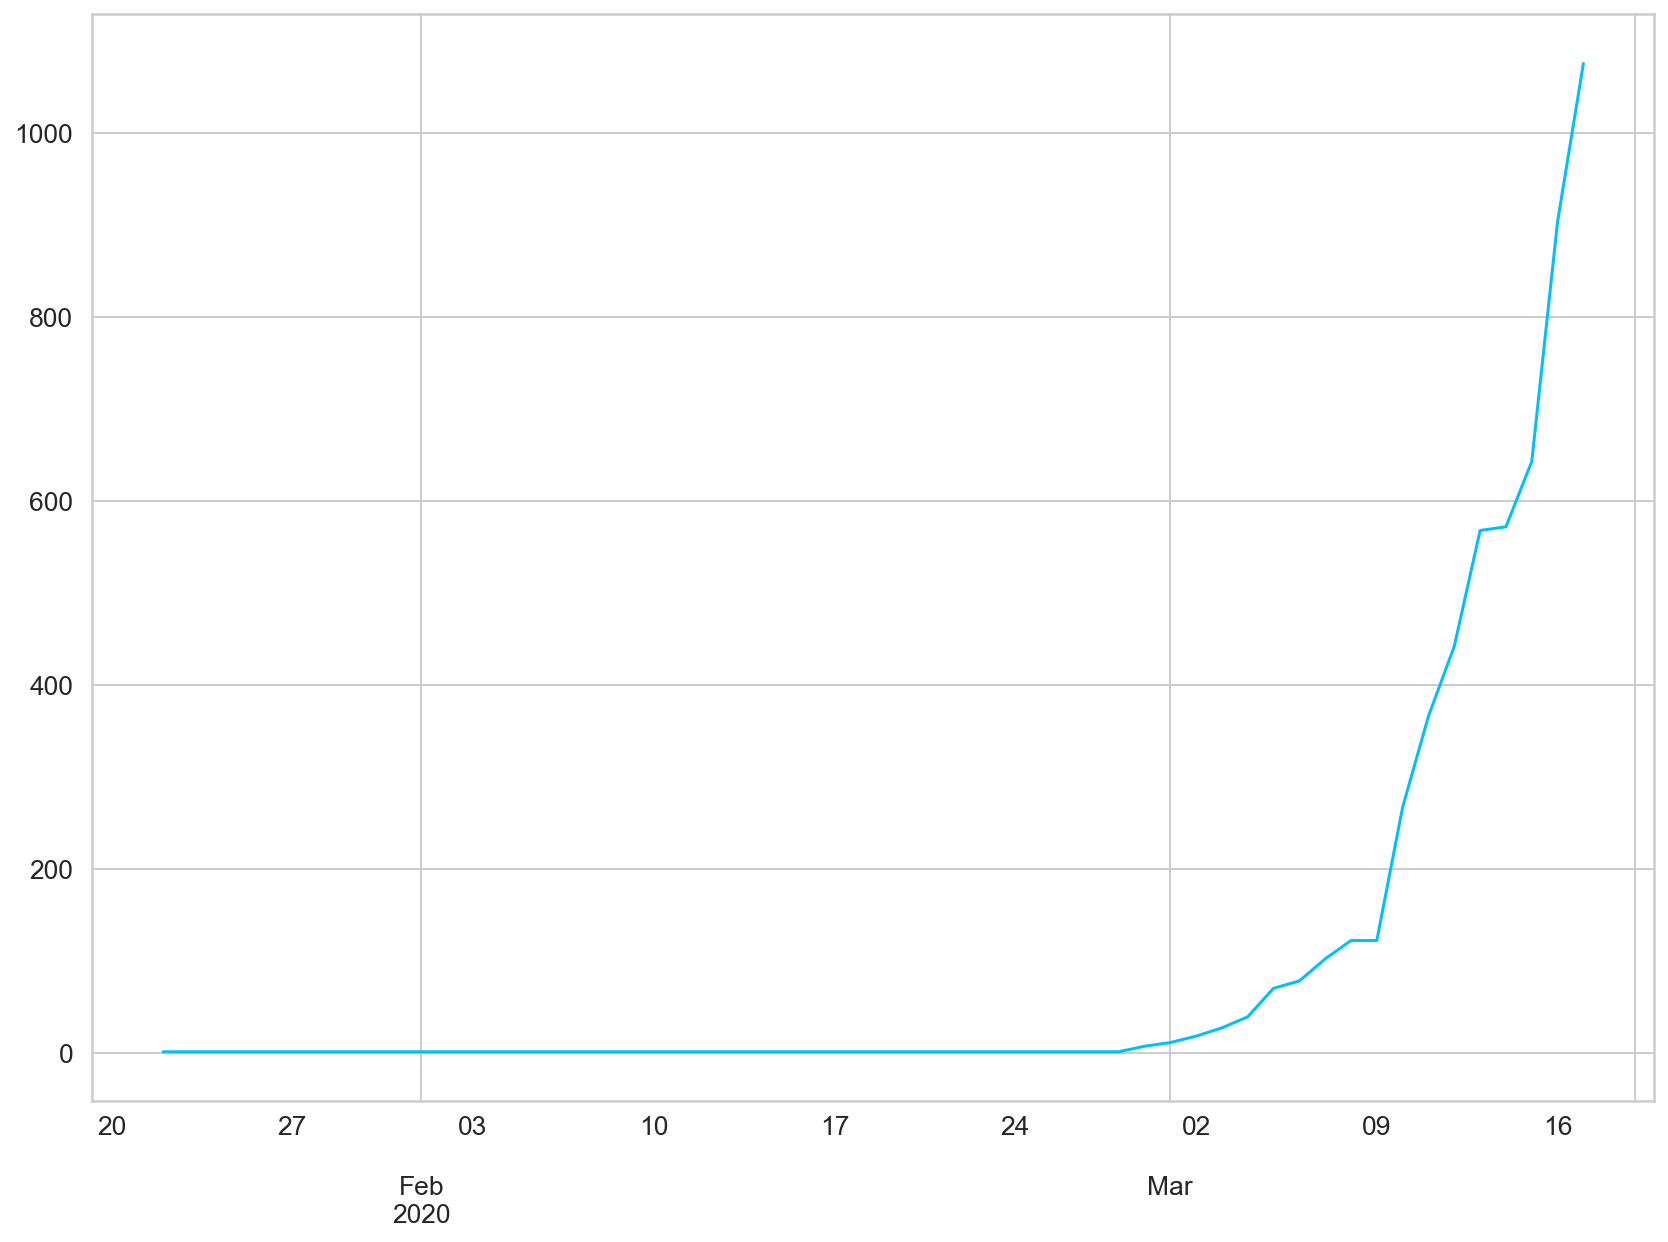

In [65]:
test_dl.df.plot()

In [18]:
test_dl.gen_data_sets(test_data_size=5)

In [22]:
test_dl.test_data.shape

(5, 1)

In [28]:
X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

In [29]:
X_test, y_test = test_dl.set_seq(train=False)

In [30]:
X_train, y_train = test_dl.set_seq()
X_test, y_test = test_dl.set_seq(train=False)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [31]:
y_test.shape

torch.Size([1, 1])

In [66]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.3
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [67]:
def train_model(model, train_data, train_labels, test_data=None,test_labels=None, n_epochs=300):
    
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)

  train_hist = np.zeros(n_epochs)
  test_hist = np.zeros(n_epochs)

  for t in range(n_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

  return model.eval(), train_hist, test_hist

In [68]:
test_dl.sequence_lenth

3

In [ ]:
data_saver = {}

for s in state_abrs:
    print(s)
    
    # Instanial our loader / transformer
    test_dl = LSTM_data_loader(df=tdf,
                          region_abr=s,
                          country='US',
                          region_list=state_abrs,
                          state_mapper=state_mapper,
                          sequence_lenth=2)
    
    test_dl.subset_df()
    test_dl.transform_df_datetime()
    test_dl.gen_data_sets(test_data_size=5)

    X_train, y_train = test_dl.set_seq()
    X_test, y_test = test_dl.set_seq(train=False)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    
    model = CoronaVirusPredictor(
      n_features=1,
      n_hidden=512,
      seq_len=test_dl.sequence_lenth,
      n_layers=2
    )
    
    model, train_hist, test_hist = train_model(
      model,
      X_train,
      y_train,
      X_test,
      y_test
    )
    
    with torch.no_grad():
        test_seq = X_test[:1]
        preds = []
        for _ in range(len(X_test)):
            y_test_pred = model(test_seq)
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(1, test_dl.sequence_lenth, 1).float()
        
    true_cases = test_dl.scaler.inverse_transform(
        np.expand_dims(y_test.flatten().numpy(), axis=0)
    ).flatten()

    predicted_cases = test_dl.scaler.inverse_transform(
      np.expand_dims(preds, axis=0)
    ).flatten()
    
    data_saver[s] = {
        'train_hist' : train_hist,
        'test_hist' : test_hist,
        'xtrain' : X_train,
        'xtest' : X_test,
        'ytrain' : y_test,
        'ytest' : y_test,
        'true_cases' : true_cases,
        'predicted_cases' : predicted_cases
    }
    
#     print(data_saver)
    

AL
Epoch 0 train loss: 0.015116780996322632 test loss: 840.7821044921875
Epoch 10 train loss: 0.000842939771246165 test loss: 841.9154663085938
Epoch 20 train loss: 0.00034307068563066423 test loss: 841.4600219726562
Epoch 30 train loss: 6.466620834544301e-05 test loss: 841.6046752929688
Epoch 40 train loss: 4.568230360746384e-05 test loss: 841.0740356445312
Epoch 50 train loss: 5.4447704314952716e-05 test loss: 841.3905639648438
Epoch 60 train loss: 3.3299300412181765e-05 test loss: 841.512939453125
Epoch 70 train loss: 2.7880714696948417e-05 test loss: 841.5054321289062
Epoch 80 train loss: 1.38671493914444e-05 test loss: 841.2974853515625
Epoch 90 train loss: 2.727984610828571e-05 test loss: 841.1526489257812
Epoch 100 train loss: 1.6872987544047646e-05 test loss: 841.3693237304688
Epoch 110 train loss: 1.7924165149452165e-05 test loss: 841.260986328125
Epoch 120 train loss: 9.405270247953013e-06 test loss: 841.2653198242188
Epoch 130 train loss: 1.1219893167435657e-05 test loss: 84

Epoch 240 train loss: 0.02716771699488163 test loss: 13.419187545776367
Epoch 250 train loss: 0.02716328576207161 test loss: 13.418224334716797
Epoch 260 train loss: 0.027191972360014915 test loss: 13.418869018554688
Epoch 270 train loss: 0.027178103104233742 test loss: 13.418645858764648
Epoch 280 train loss: 0.027196185663342476 test loss: 13.419631004333496
Epoch 290 train loss: 0.027194391936063766 test loss: 13.419716835021973
CA
Epoch 0 train loss: 1.5589170455932617 test loss: 6.199007987976074
Epoch 10 train loss: 1.336113691329956 test loss: 5.893967151641846
Epoch 20 train loss: 1.3174742460250854 test loss: 5.796813011169434
Epoch 30 train loss: 1.3210148811340332 test loss: 5.830250263214111
Epoch 40 train loss: 1.3108105659484863 test loss: 5.846858978271484
Epoch 50 train loss: 1.3056042194366455 test loss: 5.788836479187012
Epoch 60 train loss: 1.2994680404663086 test loss: 5.788129806518555
Epoch 70 train loss: 1.2997872829437256 test loss: 5.785080909729004
Epoch 80 tr

Epoch 210 train loss: 0.9788953065872192 test loss: 63.66207504272461
Epoch 220 train loss: 0.9792458415031433 test loss: 63.6580810546875
Epoch 230 train loss: 0.9785518646240234 test loss: 63.65434646606445
Epoch 240 train loss: 0.9784905910491943 test loss: 63.65913772583008
Epoch 250 train loss: 0.9786286950111389 test loss: 63.66182327270508
Epoch 260 train loss: 0.9789419770240784 test loss: 63.670166015625
Epoch 270 train loss: 0.9783501029014587 test loss: 63.65839385986328
Epoch 280 train loss: 0.9782195091247559 test loss: 63.66166687011719
Epoch 290 train loss: 0.9786189794540405 test loss: 63.65826416015625
FL
Epoch 0 train loss: 1.0808014869689941 test loss: 19.559371948242188
Epoch 10 train loss: 0.9819851517677307 test loss: 19.15243911743164
Epoch 20 train loss: 0.9718008041381836 test loss: 19.061920166015625
Epoch 30 train loss: 0.9792823791503906 test loss: 19.129440307617188
Epoch 40 train loss: 0.9691051840782166 test loss: 19.09193229675293
Epoch 50 train loss: 0.

Epoch 180 train loss: 5.682180926669389e-06 test loss: 24.99638557434082
Epoch 190 train loss: 1.0674978511815425e-05 test loss: 25.000991821289062
Epoch 200 train loss: 6.933822533028433e-06 test loss: 25.00417709350586
Epoch 210 train loss: 6.656477125943638e-06 test loss: 25.00012969970703
Epoch 220 train loss: 6.5797908064268995e-06 test loss: 24.996601104736328
Epoch 230 train loss: 5.295514711178839e-06 test loss: 24.994722366333008
Epoch 240 train loss: 6.076490080886288e-06 test loss: 24.994802474975586
Epoch 250 train loss: 6.529847269121092e-06 test loss: 24.998126983642578
Epoch 260 train loss: 5.505810804606881e-06 test loss: 24.994802474975586
Epoch 270 train loss: 8.209446605178528e-06 test loss: 24.9930477142334
Epoch 280 train loss: 7.410252237605164e-06 test loss: 24.993419647216797
Epoch 290 train loss: 7.573821221740218e-06 test loss: 24.99251937866211
IL
Epoch 0 train loss: 0.7534053325653076 test loss: 10.408665657043457
Epoch 10 train loss: 0.6531982421875 test lo

Epoch 150 train loss: 2.748412847518921 test loss: 105.03233337402344
Epoch 160 train loss: 2.6001014709472656 test loss: 102.43873596191406
Epoch 170 train loss: 2.400012493133545 test loss: 99.32608795166016
Epoch 180 train loss: 2.1820831298828125 test loss: 96.0388412475586
Epoch 190 train loss: 1.9551095962524414 test loss: 90.55964660644531
Epoch 200 train loss: 1.7294142246246338 test loss: 87.01893615722656
Epoch 210 train loss: 1.513485312461853 test loss: 80.54681396484375
Epoch 220 train loss: 1.3868120908737183 test loss: 77.11263275146484
Epoch 230 train loss: 1.1907981634140015 test loss: 73.17290496826172
Epoch 240 train loss: 1.1440991163253784 test loss: 70.36378479003906
Epoch 250 train loss: 1.0348793268203735 test loss: 71.68871307373047
Epoch 260 train loss: 1.0059469938278198 test loss: 65.79500579833984
Epoch 270 train loss: 0.9297121167182922 test loss: 67.73819732666016
Epoch 280 train loss: 0.9782529473304749 test loss: 68.1329345703125
Epoch 290 train loss: 0

Epoch 110 train loss: 1.269925832748413 test loss: 11.059244155883789
Epoch 120 train loss: 1.2624435424804688 test loss: 11.0684175491333
Epoch 130 train loss: 1.2606041431427002 test loss: 11.042865753173828
Epoch 140 train loss: 1.2602542638778687 test loss: 11.017129898071289
Epoch 150 train loss: 1.2493548393249512 test loss: 10.983449935913086
Epoch 160 train loss: 1.2423734664916992 test loss: 10.943428039550781
Epoch 170 train loss: 1.23664391040802 test loss: 10.911760330200195
Epoch 180 train loss: 1.227285623550415 test loss: 10.864859580993652
Epoch 190 train loss: 1.2227773666381836 test loss: 10.798946380615234
Epoch 200 train loss: 1.211890459060669 test loss: 10.845260620117188
Epoch 210 train loss: 1.2018940448760986 test loss: 10.743834495544434
Epoch 220 train loss: 1.1991299390792847 test loss: 10.690139770507812
Epoch 230 train loss: 1.1817700862884521 test loss: 10.644877433776855
Epoch 240 train loss: 1.1655360460281372 test loss: 10.535587310791016
Epoch 250 tra

In [49]:
save_the_data_317 = data_saver

In [35]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=test_dl.sequence_lenth,
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 13.389084815979004 test loss: 1.9732123613357544
Epoch 10 train loss: 8.327491760253906 test loss: 1.5774154663085938
Epoch 20 train loss: 4.138882160186768 test loss: 1.0888692140579224
Epoch 30 train loss: 3.923527240753174 test loss: 0.6946665644645691
Epoch 40 train loss: 3.512434959411621 test loss: 0.8968299627304077
Epoch 50 train loss: 3.564000368118286 test loss: 0.9149094820022583
Epoch 60 train loss: 3.469043731689453 test loss: 0.8279104232788086
Epoch 70 train loss: 3.4717698097229004 test loss: 0.863163948059082
Epoch 80 train loss: 3.4912571907043457 test loss: 0.855752170085907
Epoch 90 train loss: 3.526294469833374 test loss: 0.8283991813659668
Epoch 100 train loss: 3.4745535850524902 test loss: 0.8497444987297058
Epoch 110 train loss: 3.442981481552124 test loss: 0.8435304760932922
Epoch 120 train loss: 3.3929386138916016 test loss: 0.8195550441741943
Epoch 130 train loss: 3.3693761825561523 test loss: 0.8279690146446228
Epoch 140 train loss: 3.379

In [ ]:
seq_length 

with torch.no_grad():
    test_seq = X_test[:1]
    print(test_seq)
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
        
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 10))
plt.legend()

In [ ]:
mask1 = confirmed_melted['Date'].str.contains(first_day)
mask2 = confirmed_melted['Country/Region'].str.contains('US')
first_day_df_US = confirmed_melted[mask1 & mask2]
first_day_df_US.head()

first_day_df_US = first_day_df_US[['Province/State','Confirmed']]

for x in state_abrs:
    counter=0
    for r in first_day_df_US['Province/State']:
        if x in r:
            first_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            first_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        

first_day_df_US = first_day_df_US.groupby('Province/State').sum().reset_index()
first_day_df_US.head()

In [ ]:
mask = confirmed_melted['Country/Region'].str.contains('US')
first_day_df_US = confirmed_melted[mask1 & mask2]
first_day_df_US.head()

first_day_df_US = first_day_df_US[['Province/State','Confirmed']]

for x in state_abrs:
    counter=0
    for r in first_day_df_US['Province/State']:
        if x in r:
            first_day_df_US['Province/State'].iloc[counter] = x
        elif r in state_mapper.keys():
            first_day_df_US['Province/State'].iloc[counter] = remap_to_abr(r, state_mapper)
        counter+=1
        

first_day_df_US = first_day_df_US.groupby('Province/State').sum().reset_index()
first_day_df_US.head()